In [1]:
from src.all_functions import *
from src.communities.communities import *

In [2]:
import _pickle as pickle
#Python Libraries for Mongos Database
import pymongo
from pymongo import MongoClient

In [3]:
from collections import Counter, defaultdict
import itertools
import operator

In [4]:
import networkx as nx
import pandas as pd
pd.set_option('display.max_rows', 100)

In [5]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# Recipe Puppy API

In [6]:
pickle_in = open("./data/pandas/flavorDB_pandas.pickle","rb")

#Getting the dictionary from the pickle
flavorDB = pickle.load(pickle_in)

In [7]:
pickle_in = open("./data/pandas/mongodb_recipe_puppy_pandas","rb")

#Getting the dictionary from the pickle
recipe_puppy_api = pickle.load(pickle_in)

In [8]:
recipe_puppy_api.drop_duplicates(subset="recipe_name")

,_id,recipe_ingredients,recipe_link,recipe_name,searched_ingredient
0,5caa762213218a112b0b979f,"[dashi, egg, egg noodles, mushroom, salt, seas...",http://www.grouprecipes.com/31653/egg-noodles-...,Egg Noodles With Wonton Egg And Veggie Recipe,egg
1,5caa762213218a112b0b97a0,"[egg, water]",http://www.recipezaar.com/Egg-Peeling-for-Egg-...,Egg Peeling for Egg Salad,egg
2,5caa762213218a112b0b97a1,"[black pepper, celery, cucumber, curry powder,...",http://www.recipezaar.com/Curried-Egg-Salad-on...,Curried Egg Salad on a Bed of Greens -- an Egg...,egg
3,5caa762213218a112b0b97a2,"[baking powder, butter, egg, green onion, rame...",http://www.recipezaar.com/Ramen-Noodle-Egg-Foo...,Ramen Noodle Egg Foo Yung,egg
4,5caa762213218a112b0b97a3,"[bacon, black pepper, cheese, egg, salt]",http://www.recipezaar.com/Bacon-and-Egg-Cups-1...,Bacon and Egg Cups,egg
5,5caa762213218a112b0b97a4,"[celery, dijon mustard, egg, mayonnaise, papri...",http://www.recipezaar.com/Egg-Salad-Sandwich-D...,Egg Salad Sandwich (Diabetic),egg
6,5caa762213218a112b0b97a5,"[bread, egg, nonstick cooking spray]",http://www.recipezaar.com/Joleans-Sick-Egg-Rec...,"Jolean's "" Sick Egg"" Recipe",egg
7,5caa762213218a112b0b97a6,"[bread, chipotle pepper, egg, ranch dressing]",http://www.recipezaar.com/Greaneyes-Chipotle-T...,Greaneyes Chipotle Tabasco Egg Sandwich,egg
8,5caa762213218a112b0b97a7,"[butter, egg, ground beef, onions, sweet pepper]",http://www.recipezaar.com/Dr-Kims-Egg-Roll-211044,Dr. Kim's Egg Roll,egg
9,5caa762213218a112b0b97a8,"[egg, green onion, milk, salt, tortilla]",http://www.recipezaar.com/Easy-Egg-Wraps-77991,Easy Egg Wraps,egg


In [9]:
searched_ingredient_list = flavorDB["ingredient"].tolist()

In [10]:
print("Total number of ingredients searched: ", len(searched_ingredient_list))

Total number of ingredients searched:  516


In [11]:
recipe_puppy_api = recipe_puppy_api[recipe_puppy_api["searched_ingredient"].isin(searched_ingredient_list)]

In [12]:
from IPython.display import display
display(recipe_puppy_api.head(100))

,_id,recipe_ingredients,recipe_link,recipe_name,searched_ingredient
41303,5caa7ab813218a112b0c38f6,[clam],http://www.grouprecipes.com/12330/bake-clam.html,Bake Clam Recipe,clam
41304,5caa7ab813218a112b0c38f7,"[butter, clam, clams, crackers, onions]",http://cookeatshare.com/recipes/hot-clam-dip-2040,Hot Clam Dip Recipe,clam
41305,5caa7ab813218a112b0c38f8,"[broccoli, cavatelli, clam, garlic, olive oil,...",http://www.grouprecipes.com/68551/white-clam-s...,White Clam Sauce And Shrimp Recipe,clam
41306,5caa7ab813218a112b0c38f9,"[chilli, clam, ginger, salt, water]",http://www.grouprecipes.com/11784/steam-clam.html,Steam Clam Recipe,clam
41307,5caa7ab813218a112b0c38fa,"[butter, clam, milk, onions, parsley, potato, ...",http://www.recipezaar.com/Clam-Chowder-7155,Clam Chowder,clam
41308,5caa7ab813218a112b0c38fb,"[butter, clam, clams, cream of celery soup, cr...",http://cookeatshare.com/recipes/crock-pot-clam...,Crock Pot Clam Chowder Recipe,clam
41309,5caa7ab813218a112b0c38fc,"[clam, milk]",http://recipe.aol.com/recipe/new-england-clam-...,New England Clam Chowder,clam
41310,5caa7ab813218a112b0c38fd,"[butter, clam, fettuccine, garlic, lemon juice...",http://find.myrecipes.com/recipes/recipefinder...,Fettuccine with Clam Sauce and Potatoes,clam
41311,5caa7ab813218a112b0c38fe,"[clam, cream of celery soup, cream of potato s...","http://www.cooks.com/rec/view/0,1841,155172-24...",Quick Clam Chowder,clam
41312,5caa7ab813218a112b0c38ff,"[clam, clams, cream of potato soup]","http://www.cooks.com/rec/view/0,1948,157191-25...",Clam Chowder,clam


In [13]:
print("number of recipes: ", recipe_puppy_api.shape[0])

number of recipes:  95272


In [14]:
ingredient_list = []
for _, rows in recipe_puppy_api.iterrows():
    for ing in rows["recipe_ingredients"]:
        ingredient_list.append(ing)

In [15]:
print("Number of ingredients in Recipe Puppy API: ", len(ingredient_list))

Number of ingredients in Recipe Puppy API:  680476


In [16]:
Counter(ingredient_list)

Counter({'clam': 127,
         'butter': 23059,
         'clams': 181,
         'crackers': 502,
         'onions': 13672,
         'broccoli': 801,
         'cavatelli': 8,
         'garlic': 17834,
         'olive oil': 17582,
         'red pepper': 2763,
         'salt': 33353,
         'shrimp': 2245,
         'tomato': 4998,
         'chilli': 508,
         'ginger': 5165,
         'water': 14253,
         'milk': 7372,
         'parsley': 6710,
         'potato': 3337,
         'cream of celery soup': 123,
         'cream of potato soup': 36,
         'half and half': 839,
         'lowfat milk': 1377,
         'fettuccine': 173,
         'lemon juice': 9811,
         'cream cheese': 2916,
         'garlic powder': 1472,
         'hot sauce': 1217,
         'worcestershire sauce': 1459,
         'ketchup': 535,
         'mushroom': 2922,
         'pasta': 979,
         'sauce': 685,
         'cream of mushroom soup': 739,
         'vegetable oil': 9779,
         'corn': 999,
    

In [17]:
print("Number of unique ingredients in Recipe Puppy API: ", len(Counter(ingredient_list)))

Number of unique ingredients in Recipe Puppy API:  1617


In [18]:
ingredient_counter = pd.DataFrame.from_dict(Counter(ingredient_list), orient='index').reset_index()

In [19]:
ingredient_counter = ingredient_counter.rename(columns= {"index": "ingredient", 0: "quantity"})

In [20]:
ingredient_counter = ingredient_counter.sort_values(by= ["quantity"], ascending= False)

In [21]:
ingredient_counter.head(100)

,ingredient,quantity
10,salt,33353
1,butter,23059
174,sugar,21997
7,garlic,17834
8,olive oil,17582
39,black pepper,17310
55,eggs,14426
51,flour,14267
15,water,14253
4,onions,13672


In [22]:
ingredient_counter = ingredient_counter.set_index('ingredient')

In [23]:
ingredient_counter

,quantity
ingredient,
salt,33353
butter,23059
sugar,21997
garlic,17834
olive oil,17582
black pepper,17310
eggs,14426
flour,14267
water,14253


In [24]:
ingredient_counter["quantity"].describe()

count     1617.000000
mean       420.826221
std       1717.249597
min          1.000000
25%         13.000000
50%         41.000000
75%        188.000000
max      33353.000000
Name: quantity, dtype: float64

<function matplotlib.pyplot.show(*args, **kw)>

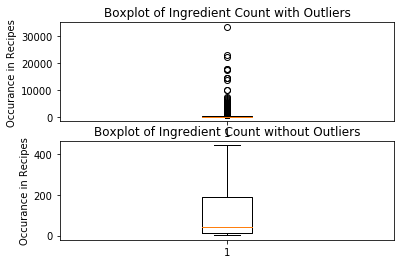

In [25]:
fig, axs = plt.subplots(2)
axs[0].boxplot(ingredient_counter["quantity"])
axs[0].set_title('Boxplot of Ingredient Count with Outliers')
axs[0].set_ylabel("Occurance in Recipes")

axs[1].boxplot(ingredient_counter["quantity"], 0, '')
axs[1].set_title('Boxplot of Ingredient Count without Outliers')
axs[1].set_ylabel("Occurance in Recipes")

plt.show

In [26]:
stop_ingredients = ingredient_counter.head(13).index.tolist() + ['baking powder', 'baking soda', "cornstarch"]

In [27]:
stop_ingredients

['salt',
 'butter',
 'sugar',
 'garlic',
 'olive oil',
 'black pepper',
 'eggs',
 'flour',
 'water',
 'onions',
 'lemon juice',
 'vegetable oil',
 'milk',
 'baking powder',
 'baking soda',
 'cornstarch']

In [70]:
ingredient_counter = ingredient_counter.drop(stop_ingredients)
ingredient_counter.head()

KeyError: "['salt' 'butter' 'sugar' 'garlic' 'olive oil' 'black pepper' 'eggs'\n 'flour' 'water' 'onions' 'lemon juice' 'vegetable oil' 'milk'\n 'baking powder' 'baking soda' 'cornstarch'] not found in axis"

In [30]:
flavorDB["ingredient"].tolist()

['sea buckthorns',
 'clam',
 'crab',
 'crayfish',
 'kelp',
 'krill',
 'lobster',
 'mollusc',
 'oyster',
 'prawn',
 'scallop',
 'shellfish',
 'shrimp',
 'trassi',
 'bonito',
 'caviar',
 'codfish',
 'fish',
 'fatty fish',
 'lean fish',
 'fish oil',
 'smoked fish',
 'salmon',
 'apple',
 'apple sauce',
 'apricot',
 'avocado',
 'babaco',
 'banana',
 'beli',
 'byrsonima crassifolia',
 'cashew apple',
 'cherimoya',
 'coconut',
 'currant',
 'black currant',
 'red currant',
 'white currant',
 'dates',
 'durian',
 'feijoa',
 'fig',
 'grape',
 'guava',
 'hogplum',
 'jackfruit',
 'kiwifruit',
 'litchi',
 'loquat',
 'malay apple',
 'mango',
 'melon',
 'musk melon',
 'naranjilla',
 'orange',
 'bitter orange',
 'papaya',
 'mountain papaya',
 'passionfruit',
 'yellow passionfruit',
 'pawpaw',
 'peach',
 'pear',
 'bartlett pear',
 'prickly pear',
 'pepino',
 'pineapple',
 'plum',
 'plumcot',
 'pumpkin',
 'quince',
 'chinese quince',
 'raisin',
 'roseapple',
 'sapodilla',
 'soursop',
 'spineless monkey 

In [31]:
uniqeue_list_of_recipe_puppy_ingredients = list(set(ingredient_list))

In [32]:
standarize_ingredient_dict = {}
for ing in uniqeue_list_of_recipe_puppy_ingredients:
    king_tup = [ing, 0]
    for ing_2 in searched_ingredient_list:
        fuzz_ratio = fuzz.ratio(ing, ing_2)
        if  fuzz_ratio > king_tup[1]:
            king_tup = [ing_2, fuzz_ratio]
    if king_tup[1] >= 85:
        standarize_ingredient_dict[ing] = king_tup[0]

In [33]:
standarize_ingredient_dict

{'hazelnuts': 'hazelnut',
 'amaranth': 'amaranth',
 'almond': 'almond',
 'endive': 'endive',
 'poppy seed': 'poppy seed',
 'applesauce': 'apple sauce',
 'peanut': 'peanut',
 'orange': 'orange',
 'mexican oregano': 'mexican oregano',
 'tarragon': 'tarragon',
 'tumeric': 'turmeric',
 'salmon': 'salmon',
 'star fruit': 'starfruit',
 'beef': 'beef',
 'butternut squash': 'butternut squash',
 'brussels sprout': 'brussels sprout',
 'persimmons': 'persimmon',
 'grapes': 'grape',
 'rutabaga': 'rutabaga',
 'figs': 'fig',
 'curry leaf': 'curry leaf',
 'rabbits': 'rabbit',
 'anchovy': 'anchovy',
 'garlic': 'garlic',
 'raisin': 'raisin',
 'corn': 'acorn',
 'chocolate spread': 'chocolate spread',
 'brazil nut': 'brazil nut',
 'jalapeno': 'jalapeno',
 'rhubarb': 'rhubarb',
 'peppers': 'pepper',
 'raisins': 'raisin',
 'star anise': 'star anise',
 'pheasant': 'pheasant',
 'cherry': 'cherry',
 'pineapple': 'pineapple',
 'chocolate': 'chocolate',
 'cinnamon': 'cinnamon',
 'ginkgo nuts': 'ginkgo nuts',
 '

In [35]:
standarize_ingredient_dict_rest = {}
for ing in uniqeue_list_of_recipe_puppy_ingredients:
    king_tup = [ing, 0]
    for ing_2 in searched_ingredient_list:
        fuzz_ratio = fuzz.ratio(ing, ing_2)
        if  fuzz_ratio > king_tup[1]:
            king_tup = [ing_2, fuzz_ratio]
        standarize_ingredient_dict_rest[ing] = (king_tup[0], king_tup[1])

In [36]:
standarize_ingredient_dict_rest

{'rum flavoring': ('true frog', 55),
 'hazelnuts': ('hazelnut', 94),
 'wax beans': ('green beans', 60),
 'almond oil': ('almond', 75),
 'cream of coconut': ('coconut', 61),
 'garlic paste': ('garlic', 67),
 'duck breast': ('buckwheat', 60),
 'onion soup mix': ('onion', 53),
 'tostadas': ('star anise', 56),
 'amaranth': ('amaranth', 100),
 'almond': ('almond', 100),
 'pizza dough': ('spiny dogfish', 58),
 'chipotle puree': ('white pepper', 62),
 'sweet chili sauce': ('white sucker', 55),
 'peppermint extract': ('peppermint', 71),
 'endive': ('endive', 100),
 'giardiniera': ('ginger', 59),
 'tortilla': ('krill', 62),
 'garlic salt': ('garlic', 71),
 'white cabbage': ('cabbage', 70),
 'cream of celery soup': ('celery', 46),
 'chili sauce': ('apple sauce', 64),
 'pot roast': ('spot croaker', 67),
 'purple plums': ('purple laver', 67),
 'poppy seed': ('poppy seed', 100),
 'adobo sauce': ('soybean sauce', 67),
 'ground meat': ('groundcherry', 61),
 'linguini': ('linden', 57),
 'loaves': ('cl

In [37]:
def cleaner(row):
    ingredient_list = row["recipe_ingredients"]
    ingredient_list = [standarize_ingredient_dict[ing] for ing in ingredient_list if ing in standarize_ingredient_dict and ing not in ["garlic", "onion"]]
    return ingredient_list

In [38]:
recipe_puppy_api["recipe_ingredients"] = recipe_puppy_api.apply(lambda row: cleaner(row), axis=1)

In [39]:
recipe_puppy_api.head(100)

,_id,recipe_ingredients,recipe_link,recipe_name,searched_ingredient
41303,5caa7ab813218a112b0c38f6,[clam],http://www.grouprecipes.com/12330/bake-clam.html,Bake Clam Recipe,clam
41304,5caa7ab813218a112b0c38f7,"[clam, clam, onion]",http://cookeatshare.com/recipes/hot-clam-dip-2040,Hot Clam Dip Recipe,clam
41305,5caa7ab813218a112b0c38f8,"[broccoli, clam, shrimp, tomato]",http://www.grouprecipes.com/68551/white-clam-s...,White Clam Sauce And Shrimp Recipe,clam
41306,5caa7ab813218a112b0c38f9,"[clam, ginger]",http://www.grouprecipes.com/11784/steam-clam.html,Steam Clam Recipe,clam
41307,5caa7ab813218a112b0c38fa,"[clam, onion, parsley]",http://www.recipezaar.com/Clam-Chowder-7155,Clam Chowder,clam
41308,5caa7ab813218a112b0c38fb,"[clam, clam]",http://cookeatshare.com/recipes/crock-pot-clam...,Crock Pot Clam Chowder Recipe,clam
41309,5caa7ab813218a112b0c38fc,[clam],http://recipe.aol.com/recipe/new-england-clam-...,New England Clam Chowder,clam
41310,5caa7ab813218a112b0c38fd,"[clam, parsley]",http://find.myrecipes.com/recipes/recipefinder...,Fettuccine with Clam Sauce and Potatoes,clam
41311,5caa7ab813218a112b0c38fe,[clam],"http://www.cooks.com/rec/view/0,1841,155172-24...",Quick Clam Chowder,clam
41312,5caa7ab813218a112b0c38ff,"[clam, clam]","http://www.cooks.com/rec/view/0,1948,157191-25...",Clam Chowder,clam


# Making a Graph

In [40]:
recipe_graph = graph_based_on_shared_recipe_creator(recipe_puppy_api)

TypeError: '<=' not supported between instances of 'set' and 'int'

In [112]:
recipe_graph.number_of_nodes()

162

In [111]:
recipe_graph.number_of_edges()

7182

In [113]:
recipe_graph.nodes()

NodeView(('clam', 'ginger', 'parsley', 'mushroom', 'shrimp', 'acorn', 'horseradish', 'thyme', 'celery', 'shallot', 'basil', 'white pepper', 'tomato', 'oregano', 'carrot', 'broccoli', 'marjoram', 'pepper', 'tarragon', 'green beans', 'vinegar', 'cauliflower', 'pork', 'cumin', 'lemon', 'crab', 'cabbage', 'apple', 'plum', 'cherry', 'lettuce', 'fish', 'mustard', 'chicken', 'avocado', 'almond', 'cherry pepper', 'wasabi', 'turmeric', 'honey', 'salmon', 'leek', 'lime', 'capers', 'spinach', 'nutmeg', 'kale', 'water chestnut', 'ham', 'jalapeno', 'banana', 'beef', 'coconut', 'eggplant', 'rosemary', 'cinnamon', 'allspice', 'cherry tomato', 'pecans', 'orange', 'raisin', 'saffron', 'pineapple', 'oyster', 'lobster', 'monkfish', 'sweet potato', 'parsnip', 'coriander', 'melon', 'radish', 'chervil', 'caviar', 'pear', 'fennel', 'walnut', 'mango', 'mint', 'grapefruit', 'endive', 'papaya', 'dill', 'peanut', 'okra', 'turnip', 'cardamom', 'peach', 'brussels sprout', 'lamb', 'nuts', 'sage', 'tofu', 'turkey', 

In [114]:
recipe_graph.edges()

EdgeView([('clam', 'clam'), ('clam', 'ginger'), ('clam', 'parsley'), ('clam', 'mushroom'), ('clam', 'shrimp'), ('clam', 'acorn'), ('clam', 'horseradish'), ('clam', 'thyme'), ('clam', 'celery'), ('clam', 'shallot'), ('clam', 'basil'), ('clam', 'white pepper'), ('clam', 'tomato'), ('clam', 'oregano'), ('clam', 'carrot'), ('clam', 'broccoli'), ('clam', 'marjoram'), ('clam', 'pepper'), ('clam', 'tarragon'), ('clam', 'green beans'), ('clam', 'vinegar'), ('clam', 'cauliflower'), ('clam', 'pork'), ('clam', 'cumin'), ('clam', 'lemon'), ('clam', 'beef'), ('clam', 'crab'), ('clam', 'lobster'), ('clam', 'salmon'), ('clam', 'sweet potato'), ('clam', 'chicken'), ('clam', 'oyster'), ('clam', 'leek'), ('clam', 'caviar'), ('clam', 'fish'), ('clam', 'mustard'), ('clam', 'swordfish'), ('clam', 'rosemary'), ('clam', 'cabbage'), ('clam', 'squid'), ('clam', 'saffron'), ('clam', 'coriander'), ('clam', 'sage'), ('clam', 'jalapeno'), ('clam', 'fennel'), ('clam', 'chervil'), ('clam', 'lime'), ('clam', 'cherry 

# Flavor DB

In [6]:
flavorDB.head()

,_id,category,flavor_of_molecules,ingredient,molecule_IDs,molecules,set_molecules,set_molecules_ID,molecule_quantity
127,5ca27ddc13218a1eabac6455,Berry,"[[sweet, new mown hay, green, tonka, bitte...",sea buckthorns,"[323, 107971, 7284, 10448, 7150, 638011, 8468,...","[coumarin, Daidzin, 2-Methylbutyraldehyde, 3-m...","{NSC5112, calcium lactate, (Z)-cinnamyl alcoho...","{8468, 61020, 323, 1110, 446925, 878, 26447, 7...",113
133,5ca27de313218a1eabac645b,Seafood,"[[cherry, caramel, nut, phenolic], [apple, ...",clam,"[14511, 8785, 8193, 8163, 8063, 9862, 7909, 79...","[3-Methyl-2-Cyclohexen-1-One, Benzyl Acetate, ...","{octanoic acid, trans,trans-2,4-Heptadienal, t...","{11747, 8027, 1068, 14511, 15394, 1549778, 878...",61
134,5ca27de513218a1eabac645c,Seafood,"[[coconut, wax, fat, waxy, fatty, earthy,...",crab,"[8193, 8063, 5281, 7909, 7501, 7519, 8051, 188...","[1-Dodecanol, Pentanal, stearic acid, 4-Methyl...","{Thiazole, 2-Heptanone, thiamine, Octanal, 2-A...","{1068, 18938, 5311110, 3776, 11005, 8129, 878,...",38
135,5ca27de613218a1eabac645d,Seafood,"[[orange, waxy, fresh, fatty, floral, iri...",crayfish,"[8163, 5283321, 7501, 8051, 18635, 7002, 454, ...","[2-Undecanone, trans,trans-2,4-Heptadienal, St...","{Thiazole, 2-Heptanone, trans,trans-2,4-Heptad...","{8027, 26331, 18635, 8184, 8129, 26808, 8093, ...",32
136,5ca27de713218a1eabac645e,Seafood,"[[sweet, new mown hay, green, tonka, bitte...",kelp,"[323, 107971, 7284, 10448, 7150, 638011, 64373...","[coumarin, Daidzin, 2-Methylbutyraldehyde, 3-m...","{NSC5112, calcium lactate, Benzothiazole, (Z)-...","{61020, 11005, 323, 1110, 878, 26447, 7288, 24...",104


In [7]:
print("number of ingredients: ", flavorDB["ingredient"].count())

number of ingredients:  516


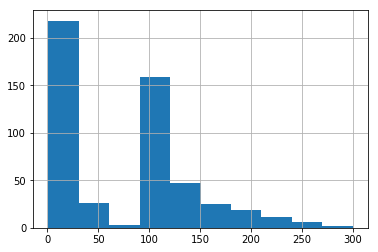

In [8]:
#Distribution of flavor molecules per ingredients
flavorDB["molecule_quantity"].hist()

In [9]:
#Distribution of flavor molecules per ingredients
flavorDB["molecule_quantity"].describe()

count    516.000000
mean      71.538760
std       67.783525
min        1.000000
25%        3.000000
50%       92.000000
75%      110.250000
max      300.000000
Name: molecule_quantity, dtype: float64

# Within Category Ratio


In [10]:
#Distribution of ingredients per category
flavorDB.groupby("category")["ingredient"].count()

category
Berry                42
Cabbage              16
Fish                120
Fruit                82
Fruit Citrus         10
Fruit Essence         1
Fungus               11
Herb                 51
Meat                 46
Nut                  21
Plant Derivative     20
Seafood              35
Spice                25
Vegetable            24
Vegetable Fruit       4
Vegetable Root        8
Name: ingredient, dtype: int64

In [11]:
"""
takes a while to process, so commented out
"""
# list_of_category_ratios = []
# for category in list_of_categories:
#     if len(ingredient_only_pd[ingredient_only_pd["category"] == category]["ingredient"]) > 1:
#         list_of_ingredients_per_category = ingredient_only_pd[ingredient_only_pd["category"] == category]["ingredient"].tolist()
#         ratio_total = 0
#         for combo in combinations(list_of_ingredients_per_category, 2):
#             ratio, x, y, z = common_pair_analysis(combo[0], combo[1])
#             ratio_total += ratio
#         category_ratio = ratio_total / len(list(combinations(list_of_ingredients_per_category, 2)))
#         list_of_category_ratios.append(category_ratio)
#         print("Ratio for {}: ".format(category), category_ratio)

'\ntakes a while to process, so commented out\n'

Ratio for Berry: 0.35719197257990054 Ratio for Fish: 0.41460354837905844 Ratio for Fruit: 0.3786900657335132 Ratio for Fruit Citrus: 0.3884684724638544 Ratio for Fungus: 0.41409691629955947 Ratio for Herb: 0.5326167800571301 Ratio for Meat: 0.13390955730473256 Ratio for Nut: 0.5507713353522316 Ratio for Plant Derivative: 0.09379168158647629 Ratio for Seafood: 0.16144490977143952 Ratio for Spice: 0.4443326703423937 Ratio for Vegetable: 0.5939392378952064 Ratio for Vegetable Root: 0.6347922930979436

(0.0044444444444444444, 8, 216, 1)

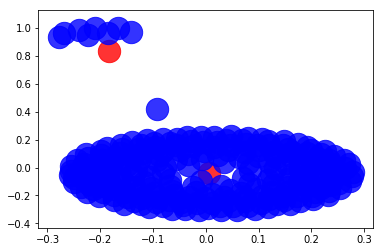

In [12]:
common_pair_analysis("celery", "peanut butter", flavorDB, True)

(0.31176470588235294, 39, 78, 53)

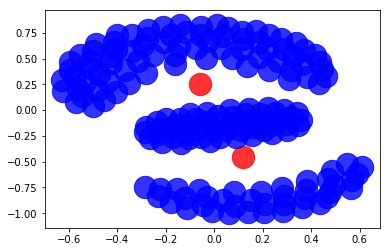

In [13]:
common_pair_analysis("chicken", "beef", flavorDB, True)

(0.05058365758754864, 244, 0, 13)

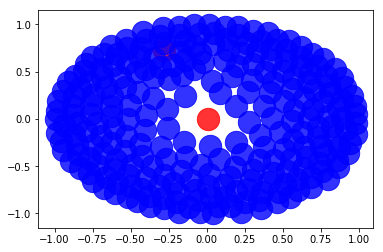

In [14]:
common_pair_analysis("chocolate", "strawberry", flavorDB, True)

# Making a Graph
graph that has ingredients as nodes and edges if the ratio is above a certain level

In [15]:
subset_flavorDB = flavorDB.sample(n = 8, random_state=5)

In [16]:
subset_ingredient_graph = graph_based_on_shared_molecule_creator(pandas_df= subset_flavorDB, min_intersection_ratio= 0)

/home/ryoiwata/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


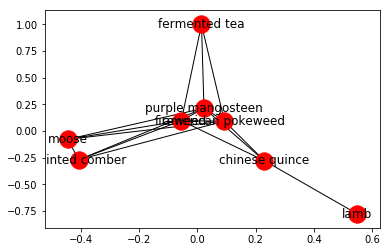

In [17]:
#Quick example of what a subset of the graph looks like
nx.draw_networkx(subset_ingredient_graph)

In [18]:
ingredient_only_graph = graph_based_on_shared_molecule_creator(pandas_df= flavorDB, min_intersection_ratio= 0)

In [19]:
print("number of nodes(ingredients) in graph: ", ingredient_only_graph.number_of_nodes())

number of nodes(ingredients) in graph:  515


In [20]:
print("number of edges(relation of shared molecules) in graph: ", ingredient_only_graph.number_of_edges())

number of edges(relation of shared molecules) in graph:  114669


In [21]:
print("number of connected components in graph: ", nx.number_connected_components(ingredient_only_graph))

number of connected components in graph:  2


In [22]:
#Seeing which nodes are in each connected components
for comp in nx.connected_components(ingredient_only_graph):
    print(comp)

{'spiny lobster', 'eggplant', 'calamus', 'carrot', 'hazelnut', 'pitanga', 'burbot', 'morchella', 'jalapeno', 'tangerine', 'milkfish', 'beaver', 'canada blueberry', 'grape', 'beluga whale', 'cocoa butter', 'raccoon', 'okra', 'yellow zucchini', 'mountain papaya', 'chestnut', 'atlantic mackerel', 'curry leaf', 'sourdock', 'lingcod', 'american shad', 'ocean pout', 'tofu', 'cardamom', 'blackberry', 'raisin', 'guava', 'charr', 'caraway', 'common ling', 'truffle', 'capsicum', 'albacore tuna', 'ascidians', 'butternut', 'cherry pepper', 'epazote', 'turnip', 'horse', 'abalone', 'purple mangosteen', 'muskrat', 'mustard', 'oyster mushroom', 'garfish', 'teff', 'mexican groundcherry', 'whitefish', 'dock', 'scombridae', 'chocolate', 'mallard duck', 'black raspberry', 'acorn', 'garlic', 'onion', 'lumpsucker', 'kiwifruit', 'parsley', 'rabbit', 'atlantic pollock', 'shallot', 'komatsuna', 'honey', 'white sucker', 'sorrel', 'lime', 'safflower', 'atlantic salmon', 'rowanberry', 'krill', 'hippoglossus', 'na

In [39]:
ingredient_only_graph.remove_node("storax")

# EDA with Ingredient Only Graph

In [47]:
#commented out because it takes a while to load

ing_betweenness_centrality = nx.betweenness_centrality(ingredient_only_graph, weight='weight')

sorted_ing_betweenness_centrality = sorted(ing_betweenness_centrality.items(), key=lambda kv: kv[1], reverse= True)
sorted_ing_betweenness_centrality

[('pawpaw', 0.15734649122807018),
 ('onion', 0.1533184088693957),
 ('babaco', 0.11246649610136451),
 ('asafoetida', 0.10064495004873293),
 ('cinnamon', 0.07741684941520467),
 ('spearmint', 0.06805860136452241),
 ('lamb', 0.03392650462962963),
 ('peanut butter', 0.032597770467836254),
 ('beef processed', 0.03119669834307992),
 ('fermented tea', 0.02796052631578947),
 ('salmon', 0.025146960282651072),
 ('apple', 0.023658321150097465),
 ('wild cherry', 0.017871284113060427),
 ('lemon balm', 0.016405488547758282),
 ('apple cider vinegar', 0.013000527940220984),
 ('peppermint', 0.012754325048732943),
 ('steller sea lion', 0.01087472249296077),
 ('bergamot', 0.009372208008447042),
 ('pepper', 0.008459734405458089),
 ('strawberry', 0.008109466374269006),
 ('mint', 0.00724141081871345),
 ('ginger', 0.0062134502923976605),
 ('tomato', 0.005512914230019493),
 ('caraway', 0.005313667560103953),
 ('pork', 0.005261634990253411),
 ('dill', 0.005116959064327485),
 ('spineless monkey orange', 0.004858065302144249),
 ('capsicum', 0.004629629629629629),
 ('basil', 0.004606786062378168),
 ('satsuma orange', 0.004503990009746588),
 ('creosote', 0.0044468810916179335),
 ('grape', 0.0043859649122807015),
 ('curry leaf', 0.004050925925925926),
 ('pepino', 0.003978587962962962),
 ('mushroom', 0.003380847953216374),
 ('melon', 0.0031676413255360626),
 ('peanut', 0.003152412280701754),
 ('yellow passionfruit', 0.0031447977582846004),
 ('beef', 0.0030610380116959063),
 ('black bear', 0.002963233701537797),
 ('alaska blackfish', 0.002963233701537797),
 ('bowhead whale', 0.002963233701537797),
 ('nuttall cockle', 0.002963233701537797),
 ('sea cucumber', 0.002963233701537797),
 ('ringed seal', 0.002963233701537797),
 ('broad whitefish', 0.002963233701537797),
 ('walrus', 0.002963233701537797),
 ('pineapple', 0.0024214181286549706),
 ('smoked fish', 0.0023072002923976605),
 ('drumstick leaf', 0.002086379142300195),
 ('ham', 0.001880787037037037),
 ('garcinia indica', 0.001747532894736842),
 ('shellfish', 0.001713267543859649),
 ('banana', 0.0015305190058479531),
 ('cashew apple', 0.0014810246101364523),
 ('anise hyssop', 0.0014696028265107212),
 ('star anise', 0.0013020833333333333),
 ('papaya', 0.0012335526315789473),
 ('mace', 0.0012107090643274853),
 ('cornmint', 0.0011574074074074073),
 ('guava', 0.0011421783625730994),
 ('marjoram', 0.0011117202729044834),
 ('bilberry', 0.0009975024366471734),
 ('rosemary', 0.0009822733918128654),
 ('cabbage', 0.0009746588693957114),
 ('vanilla', 0.0009137426900584795),
 ('white pepper', 0.0007690667641325536),
 ('caviar', 0.0007614522417153996),
 ('celery', 0.0007614522417153996),
 ('woodapple', 0.0005825109649122807),
 ('allspice', 0.0005710891812865497),
 ('colocasia', 0.0005177875243664717),
 ('filbert', 0.0005101730019493177),
 ('tangerine', 0.0004949439571150097),
 ('malay apple', 0.00044925682261208575),
 ('carom seed', 0.0003654970760233918),
 ('krill', 0.0003274244639376218),
 ('thyme', 0.0003121954191033138),
 ('beli', 0.0003048629160349433),
 ('durian', 0.00028173732943469784),
 ('blackberry', 0.00022843567251461987),
 ('mountain papaya', 0.00022082115009746587),
 ('fish', 0.00021320662768031188),
 ('cherry pepper', 0.00021320662768031188),
 ('green beans', 0.00020559210526315788),
 ('sour cherry', 0.0001979775828460039),
 ('rocket salad', 0.0001979775828460039),
 ('meat', 0.0001903630604288499),
 ('nuts', 0.0001865557992202729),
 ('garlic', 0.0001827485380116959),
 ('bonito', 0.0001675194931773879),
 ('linden', 0.0001599049707602339),
 ('pear', 0.00014467592592592592),
 ('mandarin orange', 0.00014086866471734892),
 ('true seal', 0.00013706140350877192),
 ('kohlrabi', 0.00012944688109161793),
 ('carrot', 0.00012183235867446393),
 ('eggplant', 0.00011802509746588693),
 ('coriander', 0.00010660331384015594),
 ('turkey berry', 9.137426900584795e-05),
 ('plumcot', 7.614522417153996e-05),
 ('citrus fruits', 7.614522417153996e-05),
 ('scotch spearmint', 7.614522417153996e-05),
 ('mustard', 7.614522417153996e-05),
 ('strawberry jam', 6.853070175438596e-05),
 ('lettuce', 6.853070175438596e-05),
 ('spinach', 6.853070175438596e-05),
 ('cranberry', 6.472344054580896e-05),
 ('kiwifruit', 6.0916179337231965e-05),
 ('vinegar', 6.0916179337231965e-05),
 ('squid', 6.0916179337231965e-05),
 ('sage', 5.330165692007797e-05),
 ('clove', 4.949439571150097e-05),
 ('soybean sauce', 4.5687134502923974e-05),
 ('cassia', 4.5687134502923974e-05),
 ('beetroot', 4.5687134502923974e-05),
 ('mollusc', 3.807261208576998e-05),
 ('avocado', 3.807261208576998e-05),
 ('passionfruit', 3.807261208576998e-05),
 ('bartlett pear', 3.807261208576998e-05),
 ('lemon', 3.807261208576998e-05),
 ('buckwheat', 3.807261208576998e-05),
 ('sukiyaki', 3.807261208576998e-05),
 ('macaroni', 3.807261208576998e-05),
 ('winter savory', 3.807261208576998e-05),
 ('pollock', 3.191157400465385e-05),
 ('atlantic halibut', 3.191157400465385e-05),
 ('anchovy', 3.191157400465385e-05),
 ('blue whiting', 3.191157400465385e-05),
 ('carp bream', 3.191157400465385e-05),
 ('sturgeon', 3.191157400465385e-05),
 ('charr', 3.191157400465385e-05),
 ('common dab', 3.191157400465385e-05),
 ('spiny dogfish', 3.191157400465385e-05),
 ('anatidae', 3.191157400465385e-05),
 ('anguilliformes', 3.191157400465385e-05),
 ('garfish', 3.191157400465385e-05),
 ('gadiformes', 3.191157400465385e-05),
 ('mountain hare', 3.191157400465385e-05),
 ('lake trout', 3.191157400465385e-05),
 ('lemon sole', 3.191157400465385e-05),
 ('lumpsucker', 3.191157400465385e-05),
 ('scombridae', 3.191157400465385e-05),
 ('norway haddock', 3.191157400465385e-05),
 ('norway pout', 3.191157400465385e-05),
 ('pikeperch', 3.191157400465385e-05),
 ('pleuronectidae', 3.191157400465385e-05),
 ('rock ptarmigan', 3.191157400465385e-05),
 ('pacific ocean perch', 3.191157400465385e-05),
 ('true sole', 3.191157400465385e-05),
 ('cetacea', 3.191157400465385e-05),
 ('fish oil', 3.0458089668615983e-05),
 ('coconut', 3.0458089668615983e-05),
 ('cardamom', 3.0458089668615983e-05),
 ('oregano', 3.0458089668615983e-05),
 ('codfish', 2.6650828460038985e-05),
 ('sea buckthorns', 2.2843567251461987e-05),
 ('lean fish', 2.2843567251461987e-05),
 ('cherimoya', 2.2843567251461987e-05),
 ('bitter orange', 2.2843567251461987e-05),
 ('quince', 2.2843567251461987e-05),
 ('calamus', 2.2843567251461987e-05),
 ('parsley', 2.2843567251461987e-05),
 ('parsnip', 1.903630604288499e-05),
 ('smelt', 1.903630604288499e-05),
 ('morchella', 1.903630604288499e-05),
 ('apricot', 1.5229044834307991e-05),
 ('mango', 1.5229044834307991e-05),
 ('orange', 1.5229044834307991e-05),
 ('peach', 1.5229044834307991e-05),
 ('chinese quince', 1.5229044834307991e-05),
 ('roseapple', 1.5229044834307991e-05),
 ('berry', 1.5229044834307991e-05),
 ('cloudberry', 1.5229044834307991e-05),
 ('mutton', 1.5229044834307991e-05),
 ('cumin', 1.5229044834307991e-05),
 ('okra', 1.5229044834307991e-05),
 ('broccoli', 1.5229044834307991e-05),
 ('shrimp', 7.614522417153996e-06),
 ('black currant', 7.614522417153996e-06),
 ('red currant', 7.614522417153996e-06),
 ('loquat', 7.614522417153996e-06),
 ('soursop', 7.614522417153996e-06),
 ('blueberry', 7.614522417153996e-06),
 ('fennel', 7.614522417153996e-06),
 ('tarragon', 7.614522417153996e-06),
 ('chicken', 7.614522417153996e-06),
 ('mustard oil', 7.614522417153996e-06),
 ('peanut oil', 7.614522417153996e-06),
 ('anise', 7.614522417153996e-06),
 ('nutmeg', 7.614522417153996e-06),
 ('cocoa powder', 7.614522417153996e-06),
 ('chocolate', 7.614522417153996e-06),
 ('apple sauce', 2.2843567251461984e-06),
 ('jalapeno', 2.2843567251461984e-06),
 ('atlantic wolffish', 7.251926111575234e-07),
 ('common octopus', 7.251926111575234e-07),
 ('turbot', 7.251926111575234e-07),
 ('greenland halibut', 7.251926111575234e-07),
 ('haddock', 7.251926111575234e-07),
 ('horse', 7.251926111575234e-07),
 ('common ling', 7.251926111575234e-07),
 ('northern pike', 7.251926111575234e-07),
 ('rainbow trout', 7.251926111575234e-07),
 ('squab', 7.251926111575234e-07),
 ('salmonidae', 7.251926111575234e-07),
 ('whiting', 7.251926111575234e-07),
 ('clupeinae', 7.251926111575234e-07),
 ('perciformes', 7.251926111575234e-07),
 ('flatfish', 7.251926111575234e-07),
 ('true frog', 7.251926111575234e-07),
 ('snail', 7.251926111575234e-07),
 ('catfish', 7.251926111575234e-07),
 ('other meat product', 7.251926111575234e-07),
 ('chocolate spread', 7.251926111575234e-07),
 ('cocoa butter', 7.251926111575234e-07),
 ('red king crab', 2.6717622516329806e-07),
 ('atlantic mackerel', 2.6717622516329806e-07),
 ('atlantic pollock', 2.6717622516329806e-07),
 ('striped bass', 2.6717622516329806e-07),
 ('northern bluefin tuna', 2.6717622516329806e-07),
 ('bluefish', 2.6717622516329806e-07),
 ('common carp', 2.6717622516329806e-07),
 ('cisco', 2.6717622516329806e-07),
 ('atlantic croaker', 2.6717622516329806e-07),
 ('cusk', 2.6717622516329806e-07),
 ('cuttlefish', 2.6717622516329806e-07),
 ('mule deer', 2.6717622516329806e-07),
 ('dolphin fish', 2.6717622516329806e-07),
 ('freshwater drum', 2.6717622516329806e-07),
 ('freshwater eel', 2.6717622516329806e-07),
 ('european anchovy', 2.6717622516329806e-07),
 ('florida pompano', 2.6717622516329806e-07),
 ('grouper', 2.6717622516329806e-07),
 ('pacific jack mackerel', 2.6717622516329806e-07),
 ('king mackerel', 2.6717622516329806e-07),
 ('leather chiton', 2.6717622516329806e-07),
 ('lingcod', 2.6717622516329806e-07),
 ('milkfish', 2.6717622516329806e-07),
 ('monkfish', 2.6717622516329806e-07),
 ('striped mullet', 2.6717622516329806e-07),
 ('muskrat', 2.6717622516329806e-07),
 ('ocean pout', 2.6717622516329806e-07),
 ('north pacific giant octopus', 2.6717622516329806e-07),
 ('pacific herring', 2.6717622516329806e-07),
 ('polar bear', 2.6717622516329806e-07),
 ('rainbow smelt', 2.6717622516329806e-07),
 ('sablefish', 2.6717622516329806e-07),
 ('spanish mackerel', 2.6717622516329806e-07),
 ('scup', 2.6717622516329806e-07),
 ('sea trout', 2.6717622516329806e-07),
 ('american shad', 2.6717622516329806e-07),
 ('shark', 2.6717622516329806e-07),
 ('sheepshead', 2.6717622516329806e-07),
 ('snapper', 2.6717622516329806e-07),
 ('greater sturgeon', 2.6717622516329806e-07),
 ('white sucker', 2.6717622516329806e-07),
 ('pumpkinseed sunfish', 2.6717622516329806e-07),
 ('tilefish', 2.6717622516329806e-07),
 ('walleye', 2.6717622516329806e-07),
 ('whelk', 2.6717622516329806e-07),
 ('yellowtail amberjack', 2.6717622516329806e-07),
 ('albacore tuna', 2.6717622516329806e-07),
 ('spiny lobster', 2.6717622516329806e-07),
 ('percoidei', 2.6717622516329806e-07),
 ('beefalo', 2.6717622516329806e-07),
 ('spot croaker', 2.6717622516329806e-07),
 ('atlantic menhaden', 2.6717622516329806e-07),
 ('jellyfish', 2.6717622516329806e-07),
 ('roe', 2.6717622516329806e-07),
 ('green turtle', 2.6717622516329806e-07),
 ('heart of palm', 2.6717622516329806e-07),
 ('ascidians', 2.6717622516329806e-07),
 ('clam', 0.0),
 ('crab', 0.0),
 ('crayfish', 0.0),
 ('kelp', 0.0),
 ('lobster', 0.0),
 ('oyster', 0.0),
 ('prawn', 0.0),
 ('scallop', 0.0),
 ('trassi', 0.0),
 ('fatty fish', 0.0),
 ('byrsonima crassifolia', 0.0),
 ('currant', 0.0),
 ('white currant', 0.0),
 ('dates', 0.0),
 ('feijoa', 0.0),
 ('fig', 0.0),
 ('hogplum', 0.0),
 ('jackfruit', 0.0),
 ('litchi', 0.0),
 ('musk melon', 0.0),
 ('naranjilla', 0.0),
 ('prickly pear', 0.0),
 ('plum', 0.0),
 ('pumpkin', 0.0),
 ('raisin', 0.0),
 ('sapodilla', 0.0),
 ('starfruit', 0.0),
 ('tamarind', 0.0),
 ('cherry', 0.0),
 ('bitter cherry', 0.0),
 ('gooseberry', 0.0),
 ('lingonberry', 0.0),
 ('loganberry', 0.0),
 ('raspberry', 0.0),
 ('grapefruit', 0.0),
 ('kumquat', 0.0),
 ('lime', 0.0),
 ('truffle', 0.0),
 ('angelica', 0.0),
 ('artemisia', 0.0),
 ('chervil', 0.0),
 ('fenugreek', 0.0),
 ('liqourice', 0.0),
 ('rhubarb', 0.0),
 ('turkey', 0.0),
 ('almond', 0.0),
 ('brazil nut', 0.0),
 ('hazelnut', 0.0),
 ('macadamia nut', 0.0),
 ('pecans', 0.0),
 ('walnut', 0.0),
 ('honey', 0.0),
 ('saffron', 0.0),
 ('turmeric', 0.0),
 ('chive', 0.0),
 ('endive', 0.0),
 ('leek', 0.0),
 ('shallot', 0.0),
 ('brussels sprout', 0.0),
 ('cauliflower', 0.0),
 ('horseradish', 0.0),
 ('radish', 0.0),
 ('turnip', 0.0),
 ('rutabaga', 0.0),
 ('wasabi', 0.0),
 ('sweet potato', 0.0),
 ('chard', 0.0),
 ('pomegranate', 0.0),
 ('poppy seed', 0.0),
 ('water chestnut', 0.0),
 ('silver linden', 0.0),
 ('redskin onion', 0.0),
 ('lemon verbena', 0.0),
 ('cashew nut', 0.0),
 ('burdock', 0.0),
 ('borage', 0.0),
 ('capers', 0.0),
 ('safflower', 0.0),
 ('chestnut', 0.0),
 ('pummelo', 0.0),
 ('japanese persimmon', 0.0),
 ('black crowberry', 0.0),
 ('black huckleberry', 0.0),
 ('swamp cabbage', 0.0),
 ('garden cress', 0.0),
 ('mexican oregano', 0.0),
 ('medlar', 0.0),
 ('mulberry', 0.0),
 ('black mulberry', 0.0),
 ('evening primrose', 0.0),
 ('pistachio', 0.0),
 ('red raspberry', 0.0),
 ('black raspberry', 0.0),
 ('sorrel', 0.0),
 ('summer savory', 0.0),
 ('cherry tomato', 0.0),
 ('rowanberry', 0.0),
 ('sparkleberry', 0.0),
 ('common verbena', 0.0),
 ('muscadine grape', 0.0),
 ('bayberry', 0.0),
 ("elliott's blueberry", 0.0),
 ('canada blueberry', 0.0),
 ('deerberry', 0.0),
 ('ginseng', 0.0),
 ('pepper c. baccatum', 0.0),
 ('pepper c. chinense', 0.0),
 ('rambutan', 0.0),
 ('welsh onion', 0.0),
 ('komatsuna', 0.0),
 ('pak choy', 0.0),
 ('jostaberry', 0.0),
 ('kai lan', 0.0),
 ('pineappple sage', 0.0),
 ('skunk currant', 0.0),
 ('abalone', 0.0),
 ('acerola', 0.0),
 ('acorn', 0.0),
 ('winter squash', 0.0),
 ('alfalfa', 0.0),
 ('amaranth', 0.0),
 ('atlantic herring', 0.0),
 ('painted comber', 0.0),
 ('beaver', 0.0),
 ('beech nut', 0.0),
 ('beluga whale', 0.0),
 ('bison', 0.0),
 ('wild boar', 0.0),
 ('breadfruit', 0.0),
 ('breadnut tree seed', 0.0),
 ('rapini', 0.0),
 ('brown bear', 0.0),
 ('buffalo', 0.0),
 ('burbot', 0.0),
 ('american butterfish', 0.0),
 ('butternut', 0.0),
 ('butternut squash', 0.0),
 ('caribou', 0.0),
 ('natal plum', 0.0),
 ('channel catfish', 0.0),
 ('chia', 0.0),
 ('chinese chestnut', 0.0),
 ('corn salad', 0.0),
 ('cottonseed', 0.0),
 ('squashberry', 0.0),
 ('devilfish', 0.0),
 ('dock', 0.0),
 ('mallard duck', 0.0),
 ('elk', 0.0),
 ('emu', 0.0),
 ('european chestnut', 0.0),
 ('fireweed', 0.0),
 ('ginkgo nuts', 0.0),
 ('greylag goose', 0.0),
 ('groundcherry', 0.0),
 ('hippoglossus', 0.0),
 ('irish moss', 0.0),
 ('japanese chestnut', 0.0),
 ('jujube', 0.0),
 ('jute', 0.0),
 ('kale', 0.0),
 ('malabar spinach', 0.0),
 ('mammee apple', 0.0),
 ('purple mangosteen', 0.0),
 ('moose', 0.0),
 ('new zealand spinach', 0.0),
 ('ohelo berry', 0.0),
 ('opossum', 0.0),
 ('ostrich', 0.0),
 ('spotted seal', 0.0),
 ('pacific rockfish', 0.0),
 ('common persimmon', 0.0),
 ('pheasant', 0.0),
 ('pili nut', 0.0),
 ('pitanga', 0.0),
 ('american pokeweed', 0.0),
 ('prairie turnip', 0.0),
 ('european rabbit', 0.0),
 ('raccoon', 0.0),
 ('malabar plum', 0.0),
 ('rose hip', 0.0),
 ('roselle', 0.0),
 ('orange roughy', 0.0),
 ('pink salmon', 0.0),
 ('chum salmon', 0.0),
 ('coho salmon', 0.0),
 ('sockeye salmon', 0.0),
 ('chinook salmon', 0.0),
 ('atlantic salmon', 0.0),
 ('salmonberry', 0.0),
 ('pacific sardine', 0.0),
 ('bearded seal', 0.0),
 ('sheefish', 0.0),
 ('hedge mustard', 0.0),
 ('squirrel', 0.0),
 ('swordfish', 0.0),
 ('teff', 0.0),
 ('mexican groundcherry', 0.0),
 ('alaska pollock', 0.0),
 ('whitefish', 0.0),
 ('tea leaf willow', 0.0),
 ('yellowfin tuna', 0.0),
 ('deer', 0.0),
 ('rabbit', 0.0),
 ('bivalvia', 0.0),
 ('great horned owl', 0.0),
 ('quail', 0.0),
 ('boysenberry', 0.0),
 ("jew's ear", 0.0),
 ('shiitake', 0.0),
 ('purple laver', 0.0),
 ('wakame', 0.0),
 ('enokitake', 0.0),
 ('epazote', 0.0),
 ('oyster mushroom', 0.0),
 ('cloud ear fungus', 0.0),
 ('maitake', 0.0),
 ('sourdock', 0.0),
 ('narrowleaf cattail', 0.0),
 ('chanterelle', 0.0),
 ('persimmon', 0.0),
 ('red algae', 0.0),
 ('kombu', 0.0),
 ('common tuna', 0.0),
 ('columbidae', 0.0),
 ('conch', 0.0),
 ('other fish product', 0.0),
 ('tofu', 0.0),
 ('cichlidae', 0.0),
 ('horned melon', 0.0),
 ('soy yogurt', 0.0),
 ('mixed nuts', 0.0),
 ('cupua\x8du', 0.0),
 ('nance', 0.0),
 ('chinese bayberry', 0.0),
 ('green zucchini', 0.0),
 ('yellow zucchini', 0.0),
 ('saskatoon berry', 0.0),
 ('nanking cherry', 0.0),
 ('japanese pumpkin', 0.0),
 ('buffalo currant', 0.0)]


ing_eigenvector_centrality = nx.eigenvector_centrality(ingredient_only_graph, weight='weight')

sorted_ing_eigenvector_centrality = sorted(ing_eigenvector_centrality.items(), key=lambda kv: kv[1], reverse= True)
sorted_ing_eigenvector_centrality

[('swamp cabbage', 0.07214028207612086),
 ('rambutan', 0.07214028207612086),
 ('komatsuna', 0.07214028207612086),
 ('abalone', 0.07214028207612086),
 ('acerola', 0.07214028207612086),
 ('acorn', 0.07214028207612086),
 ('winter squash', 0.07214028207612086),
 ('atlantic herring', 0.07214028207612086),
 ('beech nut', 0.07214028207612086),
 ('breadnut tree seed', 0.07214028207612086),
 ('american butterfish', 0.07214028207612086),
 ('butternut', 0.07214028207612086),
 ('butternut squash', 0.07214028207612086),
 ('natal plum', 0.07214028207612086),
 ('chinese chestnut', 0.07214028207612086),
 ('corn salad', 0.07214028207612086),
 ('squashberry', 0.07214028207612086),
 ('devilfish', 0.07214028207612086),
 ('dock', 0.07214028207612086),
 ('fireweed', 0.07214028207612086),
 ('irish moss', 0.07214028207612086),
 ('japanese chestnut', 0.07214028207612086),
 ('jujube', 0.07214028207612086),
 ('jute', 0.07214028207612086),
 ('mammee apple', 0.07214028207612086),
 ('new zealand spinach', 0.07214028207612086),
 ('ohelo berry', 0.07214028207612086),
 ('pili nut', 0.07214028207612086),
 ('prairie turnip', 0.07214028207612086),
 ('malabar plum', 0.07214028207612086),
 ('hedge mustard', 0.07214028207612086),
 ('mexican groundcherry', 0.07214028207612086),
 ('boysenberry', 0.07214028207612086),
 ("jew's ear", 0.07214028207612086),
 ('purple laver', 0.07214028207612086),
 ('epazote', 0.07214028207612086),
 ('cloud ear fungus', 0.07214028207612086),
 ('sourdock', 0.07214028207612086),
 ('narrowleaf cattail', 0.07214028207612086),
 ('conch', 0.07214028207612086),
 ('horned melon', 0.07214028207612086),
 ('nance', 0.07214028207612086),
 ('amaranth', 0.07203354452809496),
 ('rapini', 0.07203354452809496),
 ('chia', 0.07203354452809496),
 ('teff', 0.07203354452809496),
 ('enokitake', 0.07203354452809496),
 ('oyster mushroom', 0.07203354452809496),
 ('maitake', 0.07203354452809496),
 ('mixed nuts', 0.07203354452809496),
 ('welsh onion', 0.0719864644869924),
 ('breadfruit', 0.0719864644869924),
 ('european chestnut', 0.0719864644869924),
 ('malabar spinach', 0.0719864644869924),
 ('burbot', 0.07181086608850643),
 ('groundcherry', 0.07181086608850643),
 ('kale', 0.07181086608850643),
 ('chanterelle', 0.07181086608850643),
 ('lemon verbena', 0.07168071002351839),
 ('sparkleberry', 0.07168071002351839),
 ('muscadine grape', 0.07168071002351839),
 ('bayberry', 0.07168071002351839),
 ("elliott's blueberry", 0.07168071002351839),
 ('canada blueberry', 0.07168071002351839),
 ('deerberry', 0.07168071002351839),
 ('ginseng', 0.07168071002351839),
 ('pepper c. baccatum', 0.07168071002351839),
 ('pepper c. chinense', 0.07168071002351839),
 ('jostaberry', 0.07168071002351839),
 ('pineappple sage', 0.07168071002351839),
 ('skunk currant', 0.07168071002351839),
 ('tea leaf willow', 0.07168071002351839),
 ('great horned owl', 0.07168071002351839),
 ('chinese bayberry', 0.07168071002351839),
 ('buffalo currant', 0.07168071002351839),
 ('pak choy', 0.07166684721024165),
 ('salmonberry', 0.07166642698701196),
 ('black mulberry', 0.07156996024097002),
 ('wakame', 0.0715650044997891),
 ('black crowberry', 0.07152908274119903),
 ('black huckleberry', 0.07152908274119903),
 ('evening primrose', 0.07152908274119903),
 ('kai lan', 0.07152908274119903),
 ('borage', 0.07136886212079664),
 ('persimmon', 0.07135304285024498),
 ('red algae', 0.07135304285024498),
 ('kombu', 0.07135304285024498),
 ('cupua\x8du', 0.0712947628893489),
 ('rose hip', 0.07123338824567378),
 ('american pokeweed', 0.0711606141415319),
 ('purple mangosteen', 0.07110206932426869),
 ('rowanberry', 0.07108575172608408),
 ('silver linden', 0.07106411550290187),
 ('mulberry', 0.07105128318036555),
 ('common verbena', 0.07101443512040032),
 ('cherry tomato', 0.07097113999825458),
 ('pitanga', 0.07093912047547657),
 ('sorrel', 0.07063244352015073),
 ('alfalfa', 0.07062323557668539),
 ('black raspberry', 0.07062020566204799),
 ('saskatoon berry', 0.07053501301575091),
 ('nanking cherry', 0.07053501301575091),
 ('redskin onion', 0.07000731817587946),
 ('japanese pumpkin', 0.0696035154412151),
 ('chard', 0.06950550421900113),
 ('capers', 0.06922225562865326),
 ('chestnut', 0.06919006422999312),
 ('mexican oregano', 0.06910637732915473),
 ('medlar', 0.06907049575697878),
 ('japanese persimmon', 0.06894574492458001),
 ('dates', 0.06883469479896935),
 ('common persimmon', 0.06862156582921362),
 ('pistachio', 0.06861179969936386),
 ('yellow zucchini', 0.06824692445628329),
 ('shiitake', 0.06810044157134014),
 ('wasabi', 0.06786408526098746),
 ('garden cress', 0.06766372328531736),
 ('chervil', 0.06760845967531229),
 ('sweet potato', 0.06742562701076717),
 ('turnip', 0.06734641934370132),
 ('water chestnut', 0.06728927399399749),
 ('cashew nut', 0.06724423827462721),
 ('hogplum', 0.0667616096626935),
 ('green zucchini', 0.06663636008478292),
 ('kelp', 0.06592030628167153),
 ('burdock', 0.0658930606013847),
 ('pumpkin', 0.06578510498278271),
 ('sapodilla', 0.06571929714259336),
 ('hazelnut', 0.0654433817976178),
 ('bitter cherry', 0.0653283561865894),
 ('feijoa', 0.06500783082249455),
 ('jackfruit', 0.06465073453170735),
 ('brazil nut', 0.06449806638262545),
 ('roseapple', 0.06440916762867194),
 ('shallot', 0.06433723813097832),
 ('macadamia nut', 0.06422748222819721),
 ('loganberry', 0.06404018386927805),
 ('cottonseed', 0.06390209071186297),
 ('pummelo', 0.06359544973369388),
 ('linden', 0.0632970463555574),
 ('naranjilla', 0.06283650949078817),
 ('rutabaga', 0.06278045275596619),
 ('radish', 0.06275709015536217),
 ('brussels sprout', 0.0626384734537752),
 ('rhubarb', 0.06243509930746877),
 ('cherry', 0.062397559090082294),
 ('roselle', 0.06174344559738963),
 ('angelica', 0.06172149469752783),
 ('sea buckthorns', 0.061489674406711284),
 ('cloudberry', 0.06107521446233907),
 ('ginkgo nuts', 0.06106721915286279),
 ('endive', 0.06089666945468108),
 ('horseradish', 0.06046727927014669),
 ('beetroot', 0.05992621719009829),
 ('litchi', 0.059888420438723645),
 ('rocket salad', 0.05945885695195983),
 ('okra', 0.059142472635293736),
 ('summer savory', 0.059010979156490784),
 ('soursop', 0.058989049130652796),
 ('red raspberry', 0.058848051381317365),
 ('cauliflower', 0.058789942084881364),
 ('lingonberry', 0.05852019168118162),
 ('fenugreek', 0.05818145412576527),
 ('pomegranate', 0.0581787594095244),
 ('artemisia', 0.0578925196549877),
 ('saffron', 0.05724636113883754),
 ('broccoli', 0.057141430460831096),
 ('chive', 0.05712322985592617),
 ('almond', 0.05666315476680582),
 ('musk melon', 0.05663030098179621),
 ('leek', 0.056333785780185726),
 ('prickly pear', 0.05628195185504229),
 ('turmeric', 0.05623773626460346),
 ('parsnip', 0.056232849709716703),
 ('eggplant', 0.05575909511012053),
 ('poppy seed', 0.05562156753291241),
 ('avocado', 0.055620870688332914),
 ('kumquat', 0.05537342256285697),
 ('loquat', 0.05516159375559405),
 ('walnut', 0.05512184964069856),
 ('mustard', 0.05430101355981225),
 ('gooseberry', 0.05426730296162605),
 ('sour cherry', 0.05368585438808959),
 ('lettuce', 0.05359225990855122),
 ('spinach', 0.05341755140440428),
 ('red currant', 0.0530368961954043),
 ('safflower', 0.05302065388646802),
 ('winter savory', 0.05294375437652996),
 ('fennel', 0.05180783068705244),
 ('kohlrabi', 0.05180490592427402),
 ('cassia', 0.051727626324133455),
 ('tarragon', 0.05158208538907591),
 ('pecans', 0.05147624732457294),
 ('durian', 0.051458382086628965),
 ('garlic', 0.05138460557083301),
 ('kiwifruit', 0.051378032870275245),
 ('anise', 0.05133969477419461),
 ('quince', 0.05099602712837592),
 ('pear', 0.050644459866911476),
 ('cumin', 0.05049505294498704),
 ('blueberry', 0.050098408008935),
 ('star anise', 0.04954379446395171),
 ('carom seed', 0.04889823657582344),
 ('blackberry', 0.04860267541017354),
 ('sage', 0.04792619094428803),
 ('cornmint', 0.04759389205314321),
 ('buckwheat', 0.047206033414648546),
 ('lime', 0.04713265629584858),
 ('fig', 0.04685130081608848),
 ('tamarind', 0.04680259092317024),
 ('coconut', 0.04667997032894045),
 ('nutmeg', 0.04653528856824446),
 ('parsley', 0.0464855341413323),
 ('cherimoya', 0.04610731921510183),
 ('grapefruit', 0.04591737201778782),
 ('allspice', 0.04575062892126844),
 ('mint', 0.04565676725505801),
 ('bilberry', 0.045471322161198986),
 ('cardamom', 0.04490901387262315),
 ('cabbage', 0.04460863185979926),
 ('thyme', 0.04446134820432786),
 ('marjoram', 0.043700380518603935),
 ('clove', 0.043463601799294434),
 ('cranberry', 0.04326508506112081),
 ('mandarin orange', 0.043223369092164905),
 ('vanilla', 0.04316388303176817),
 ('lemon balm', 0.0427154772441859),
 ('cinnamon', 0.04267638780204499),
 ('carrot', 0.042236546233371766),
 ('green beans', 0.042212527493169144),
 ('raspberry', 0.04207153196710255),
 ('plum', 0.04193692994071931),
 ('oregano', 0.04137790771350638),
 ('onion', 0.04127666730440843),
 ('starfruit', 0.041197443379762555),
 ('lemon', 0.04111604843712554),
 ('coriander', 0.04082962300400924),
 ('dill', 0.04038669840950584),
 ('peach', 0.040171747930018056),
 ('apricot', 0.039211425704719714),
 ('rosemary', 0.03900782604422097),
 ('black currant', 0.038706917249363884),
 ('basil', 0.038383921384730194),
 ('banana', 0.03829447059692508),
 ('melon', 0.03777178206141001),
 ('capsicum', 0.03738172886951236),
 ('peanut', 0.037164731620644625),
 ('celery', 0.037107621759351436),
 ('pepper', 0.036494620396611874),
 ('pineapple', 0.036406873138863),
 ('peppermint', 0.03507183615384942),
 ('mushroom', 0.03501116849970849),
 ('passionfruit', 0.03496341845910681),
 ('mango', 0.034767740547404107),
 ('spearmint', 0.0341669967161802),
 ('orange', 0.034096460879900904),
 ('papaya', 0.03368071551343738),
 ('ginger', 0.033277298190104845),
 ('guava', 0.03248885419825785),
 ('strawberry', 0.03188908719337812),
 ('grape', 0.03186610202203167),
 ('tomato', 0.03103507009416231),
 ('apple', 0.028209270776118813),
 ('vinegar', 0.010787783061978109),
 ('honey', 0.007941024700791381),
 ('berry', 0.007415035545079421),
 ('crab', 0.006982590507036331),
 ('shrimp', 0.006945490676301535),
 ('colocasia', 0.0068406883781524505),
 ('scallop', 0.006600817966192014),
 ('clam', 0.0061659437562235925),
 ('tofu', 0.00607057866429526),
 ('meat', 0.006045163137851042),
 ('chicken', 0.006021470942319266),
 ('soybean sauce', 0.0059514255989952984),
 ('beef', 0.005501482043422376),
 ('chinese quince', 0.005460658927456205),
 ('filbert', 0.005459211240316265),
 ('cocoa powder', 0.005361478466948818),
 ('oyster', 0.005302219206722421),
 ('crayfish', 0.005283096871991306),
 ('squid', 0.0052566610873210845),
 ('pork', 0.005114151707455055),
 ('citrus fruits', 0.004960408022767643),
 ('greylag goose', 0.00459133564378612),
 ('pheasant', 0.00459133564378612),
 ('whitefish', 0.00459133564378612),
 ('rabbit', 0.00459133564378612),
 ('common tuna', 0.00459133564378612),
 ('other fish product', 0.00459133564378612),
 ('soy yogurt', 0.0045762260204478475),
 ('fatty fish', 0.004481135524573644),
 ('liqourice', 0.004455912233789343),
 ('beef processed', 0.004454767009705075),
 ('pink salmon', 0.0043920101677019895),
 ('chum salmon', 0.0043920101677019895),
 ('sockeye salmon', 0.0043920101677019895),
 ('chinook salmon', 0.0043920101677019895),
 ('atlantic salmon', 0.0043920101677019895),
 ('bearded seal', 0.0043920101677019895),
 ('sheefish', 0.0043920101677019895),
 ('deer', 0.0043920101677019895),
 ('cichlidae', 0.0043920101677019895),
 ('beluga whale', 0.004392010167701988),
 ('bison', 0.004392010167701988),
 ('caribou', 0.004392010167701988),
 ('ostrich', 0.004392010167701988),
 ('chocolate', 0.004370950766645148),
 ('bonito', 0.0042126764226397325),
 ('lobster', 0.0040979025494663895),
 ('calamus', 0.004049274890562359),
 ('codfish', 0.004047877026272571),
 ('atlantic wolffish', 0.003981188323715016),
 ('common octopus', 0.003981188323715016),
 ('turbot', 0.003981188323715016),
 ('greenland halibut', 0.003981188323715016),
 ('haddock', 0.003981188323715016),
 ('horse', 0.003981188323715016),
 ('common ling', 0.003981188323715016),
 ('northern pike', 0.003981188323715016),
 ('rainbow trout', 0.003981188323715016),
 ('squab', 0.003981188323715016),
 ('salmonidae', 0.003981188323715016),
 ('whiting', 0.003981188323715016),
 ('clupeinae', 0.003981188323715016),
 ('flatfish', 0.003981188323715016),
 ('snail', 0.003981188323715016),
 ('catfish', 0.003981188323715016),
 ('chocolate spread', 0.003981188323715016),
 ('cocoa butter', 0.003981188323715016),
 ('perciformes', 0.003981188323715014),
 ('true frog', 0.003981188323715014),
 ('other meat product', 0.003981188323715014),
 ('truffle', 0.0039752601466311694),
 ('pacific sardine', 0.0039650647495856955),
 ('squirrel', 0.0039650647495856955),
 ('quail', 0.0039650647495856955),
 ('columbidae', 0.0039650647495856955),
 ('beaver', 0.003965064749585695),
 ('wild boar', 0.003965064749585695),
 ('brown bear', 0.003965064749585695),
 ('mallard duck', 0.003965064749585695),
 ('moose', 0.003965064749585695),
 ('opossum', 0.003965064749585695),
 ('european rabbit', 0.003965064749585695),
 ('raccoon', 0.003965064749585695),
 ('bitter orange', 0.0038866220789304192),
 ('turkey', 0.003882297725782192),
 ('channel catfish', 0.0038091526977527663),
 ('elk', 0.0038091526977527663),
 ('emu', 0.0038091526977527663),
 ('hippoglossus', 0.0038091526977527663),
 ('spotted seal', 0.0038091526977527663),
 ('pacific rockfish', 0.0038091526977527663),
 ('orange roughy', 0.0038091526977527663),
 ('coho salmon', 0.0038091526977527663),
 ('swordfish', 0.0038091526977527663),
 ('alaska pollock', 0.0038091526977527663),
 ('yellowfin tuna', 0.0038091526977527663),
 ('bivalvia', 0.0038091526977527663),
 ('painted comber', 0.003809152697752766),
 ('buffalo', 0.003809152697752766),
 ('mutton', 0.0038016818281754387),
 ('bartlett pear', 0.0037728329290932366),
 ('mace', 0.0037196213881826364),
 ('fish', 0.003660305390761572),
 ('drumstick leaf', 0.0036170909868465085),
 ('red king crab', 0.0034728509075791147),
 ('atlantic mackerel', 0.0034728509075791147),
 ('atlantic pollock', 0.0034728509075791147),
 ('striped bass', 0.0034728509075791147),
 ('northern bluefin tuna', 0.0034728509075791147),
 ('bluefish', 0.0034728509075791147),
 ('common carp', 0.0034728509075791147),
 ('cisco', 0.0034728509075791147),
 ('atlantic croaker', 0.0034728509075791147),
 ('cusk', 0.0034728509075791147),
 ('cuttlefish', 0.0034728509075791147),
 ('mule deer', 0.0034728509075791147),
 ('dolphin fish', 0.0034728509075791147),
 ('freshwater drum', 0.0034728509075791147),
 ('freshwater eel', 0.0034728509075791147),
 ('european anchovy', 0.0034728509075791147),
 ('florida pompano', 0.0034728509075791147),
 ('grouper', 0.0034728509075791147),
 ('pacific jack mackerel', 0.0034728509075791147),
 ('king mackerel', 0.0034728509075791147),
 ('leather chiton', 0.0034728509075791147),
 ('lingcod', 0.0034728509075791147),
 ('milkfish', 0.0034728509075791147),
 ('monkfish', 0.0034728509075791147),
 ('striped mullet', 0.0034728509075791147),
 ('muskrat', 0.0034728509075791147),
 ('ocean pout', 0.0034728509075791147),
 ('north pacific giant octopus', 0.0034728509075791147),
 ('pacific herring', 0.0034728509075791147),
 ('polar bear', 0.0034728509075791147),
 ('rainbow smelt', 0.0034728509075791147),
 ('sablefish', 0.0034728509075791147),
 ('spanish mackerel', 0.0034728509075791147),
 ('scup', 0.0034728509075791147),
 ('sea trout', 0.0034728509075791147),
 ('american shad', 0.0034728509075791147),
 ('shark', 0.0034728509075791147),
 ('sheepshead', 0.0034728509075791147),
 ('snapper', 0.0034728509075791147),
 ('greater sturgeon', 0.0034728509075791147),
 ('white sucker', 0.0034728509075791147),
 ('pumpkinseed sunfish', 0.0034728509075791147),
 ('tilefish', 0.0034728509075791147),
 ('walleye', 0.0034728509075791147),
 ('whelk', 0.0034728509075791147),
 ('yellowtail amberjack', 0.0034728509075791147),
 ('albacore tuna', 0.0034728509075791147),
 ('spiny lobster', 0.0034728509075791147),
 ('percoidei', 0.0034728509075791147),
 ('beefalo', 0.0034728509075791147),
 ('spot croaker', 0.0034728509075791147),
 ('atlantic menhaden', 0.0034728509075791147),
 ('jellyfish', 0.0034728509075791147),
 ('roe', 0.0034728509075791147),
 ('green turtle', 0.0034728509075791147),
 ('heart of palm', 0.0034728509075791147),
 ('ascidians', 0.0034728509075791147),
 ('raisin', 0.0034048828977773986),
 ('mollusc', 0.003215135966773082),
 ('trassi', 0.0031761599963647472),
 ('currant', 0.003086027211164956),
 ('white currant', 0.003086027211164956),
 ('lean fish', 0.0030584646209643046),
 ('pollock', 0.0028440784700881185),
 ('atlantic halibut', 0.0028440784700881185),
 ('anchovy', 0.0028440784700881185),
 ('blue whiting', 0.0028440784700881185),
 ('carp bream', 0.0028440784700881185),
 ('sturgeon', 0.0028440784700881185),
 ('charr', 0.0028440784700881185),
 ('common dab', 0.0028440784700881185),
 ('spiny dogfish', 0.0028440784700881185),
 ('anatidae', 0.0028440784700881185),
 ('anguilliformes', 0.0028440784700881185),
 ('garfish', 0.0028440784700881185),
 ('gadiformes', 0.0028440784700881185),
 ('mountain hare', 0.0028440784700881185),
 ('lake trout', 0.0028440784700881185),
 ('lemon sole', 0.0028440784700881185),
 ('lumpsucker', 0.0028440784700881185),
 ('scombridae', 0.0028440784700881185),
 ('norway haddock', 0.0028440784700881185),
 ('norway pout', 0.0028440784700881185),
 ('pikeperch', 0.0028440784700881185),
 ('pleuronectidae', 0.0028440784700881185),
 ('rock ptarmigan', 0.0028440784700881185),
 ('pacific ocean perch', 0.0028440784700881185),
 ('true sole', 0.0028440784700881185),
 ('cetacea', 0.0028440784700881185),
 ('fish oil', 0.0028245218659008445),
 ('turkey berry', 0.0026525960033966446),
 ('white pepper', 0.0026146500725370307),
 ('sukiyaki', 0.0024983087417871034),
 ('plumcot', 0.002425057168555539),
 ('mountain papaya', 0.0024213066416089706),
 ('scotch spearmint', 0.0023236537148332414),
 ('true seal', 0.002204328837945702),
 ('smelt', 0.0021786177882911107),
 ('morchella', 0.0021786177882911102),
 ('tangerine', 0.0020316258693115594),
 ('peanut oil', 0.0020284318776780863),
 ('cherry pepper', 0.0019026542843872854),
 ('steller sea lion', 0.0019017915185829944),
 ('strawberry jam', 0.0018562367860300087),
 ('nuts', 0.0018188437928249733),
 ('caviar', 0.0017805335677483702),
 ('krill', 0.001708625169583877),
 ('black bear', 0.0016535227937077104),
 ('alaska blackfish', 0.0016535227937077104),
 ('bowhead whale', 0.0016535227937077104),
 ('nuttall cockle', 0.0016535227937077104),
 ('sea cucumber', 0.0016535227937077104),
 ('ringed seal', 0.0016535227937077104),
 ('broad whitefish', 0.0016535227937077104),
 ('walrus', 0.0016535227937077104),
 ('malay apple', 0.0016396843008062473),
 ('apple cider vinegar', 0.0015210889241568351),
 ('asafoetida', 0.0014638626877789183),
 ('yellow passionfruit', 0.001411884380087915),
 ('caraway', 0.0013836365022812588),
 ('pawpaw', 0.0010528052563711283),
 ('bergamot', 0.0010018142941965473),
 ('wild cherry', 0.000996736930293326),
 ('salmon', 0.0009966514254635581),
 ('cashew apple', 0.0008998072197748368),
 ('peanut butter', 0.0008914203691476445),
 ('curry leaf', 0.0008278300651089116),
 ('babaco', 0.000811260406402959),
 ('fermented tea', 0.0007921309260372926),
 ('anise hyssop', 0.0005174584408728424),
 ('lamb', 0.0004897574288441517),
 ('spineless monkey orange', 0.00031446215610792823),
 ('smoked fish', 0.000266776629546623),
 ('pepino', 0.0001395961100949533),
 ('garcinia indica', 0.00013883893785624388),
 ('woodapple', 0.00012192373841095423),
 ('satsuma orange', 0.00010102813164111535),
 ('ham', 9.86678177633743e-05),
 ('macaroni', 7.072702551273143e-05),
 ('creosote', 4.9668492874158634e-05),
 ('shellfish', 3.9465617214952375e-05),
 ('mustard oil', 3.818799489310957e-05),
 ('beli', 3.321034091627358e-05),
 ('jalapeno', 1.1119319737220007e-05),
 ('prawn', 6.766831326451976e-06),
 ('apple sauce', 1.9439767167194776e-06),
 ('byrsonima crassifolia', 1.2335590326197988e-06)]

# EDA with Ingredient and associated Molecule Graph


In [48]:
ing_mol_graph = graph_based_on_ingredient_with_associated_flavor_molecule_creator(flavorDB)

ing_mol_betweenness_centrality = nx.betweenness_centrality(ing_mol_graph)

sorted_ing_mol_betweenness_centrality = sorted(ing_mol_betweenness_centrality.items(), key=lambda kv: kv[1], reverse= True)
sorted_ing_mol_betweenness_centrality


sorted_ing_mol_betweenness_centrality = sorted(ing_mol_betweenness_centrality.items(), key=lambda kv: kv[1], reverse= True)
sorted_ing_mol_betweenness_centrality
[('CID 644104', 0.07458020706413207),
 ('thiamine', 0.06117896833935136),
 ('beef processed', 0.036943086446358964),
 ('tomato', 0.031792695509734854),
 ('apple', 0.030223128499144995),
 ('mushroom', 0.029778408868720303),
 ('grape', 0.028197743818670986),
 ('peppermint', 0.02706255107642641),
 ('Heptanoic Acid', 0.02517322595627346),
 ('ginger', 0.02453425078490773),
 ('pork', 0.024433920525294753),
 ('strawberry', 0.023703359693344965),
 ('spearmint', 0.023454269629743032),
 ('drumstick leaf', 0.022314953792477544),
 ('passionfruit', 0.021791027477622602),
 ('capsicum', 0.0217187321108005),
 ('onion', 0.021582488354001048),
 ('peanut', 0.021416284372316644),
 ('guava', 0.021091717376906915),
 ('pineapple', 0.019847255236297733),
 ('papaya', 0.019278501539675766),
 ('orange', 0.018865717483311825),
 ('celery', 0.01886446460111915),
 ('pepper', 0.018108363400649984),
 ('melon', 0.015309253891783583),
 ('betaine', 0.015283799166607766),
 ('Thiamine Hydrochloride', 0.015035867241067888),
 ('mango', 0.015030224325141141),
 ('banana', 0.014956869287319189),
 ('garlic', 0.014213946643555795),
 ('clove', 0.01403035357932167),
 ('basil', 0.013959053347055961),
 ('lemon', 0.013532069908485902),
 ('raspberry', 0.01315980690482162),
 ('coriander', 0.012829240039578103),
 ('asafoetida', 0.012816650451387322),
 ('starfruit', 0.012376898904111061),
 ('chicken', 0.011819884893448563),
 ('colocasia', 0.01139939960132765),
 ('black currant', 0.011322611947485621),
 ('rosemary', 0.011315241425295811),
 ('kumquat', 0.011017554183733059),
 ('durian', 0.010802011123600106),
 ('dill', 0.01079110463373805),
 ('oregano', 0.010502698711067886),
 ('peach', 0.010384144809889662),
 ('cabbage', 0.010144534590678185),
 ('vanilla', 0.01012117863596231),
 ('cinnamon', 0.010032002303501554),
 ('grapefruit', 0.009949109792838187),
 ('Propionaldehyde', 0.009842662633151101),
 ('6-Methyl-5-Hepten-2-One', 0.009560390698108254),
 ('kohlrabi', 0.009489862049339336),
 ('lemon balm', 0.009327344172756984),
 ('2-Phenylethanol', 0.009149601086355557),
 ('eggplant', 0.009074917301581631),
 ('phenylacetaldehyde', 0.0090555207730368),
 ('indole', 0.008429572614289301),
 ('marjoram', 0.00837151041357988),
 ('methanethiol', 0.00829528280083),
 ('thyme', 0.008255792750733073),
 ('cornmint', 0.008241780875952209),
 ('spinach', 0.008230248978437441),
 ('(+)-delta-Cadinene', 0.008198293522787756),
 ('plum', 0.00805885473577059),
 ('mint', 0.007973630351295573),
 ('Octanal', 0.007909745744005351),
 ('allspice', 0.007891023232403756),
 ('apricot', 0.007885378755841298),
 ('2,3-butanedione', 0.007778201920793106),
 ('filbert', 0.007774232321696195),
 ('Cyclopentanone', 0.007681761958752551),
 ('3-Methyl-1-butanol', 0.007629578337952451),
 ('cardamom', 0.007543534293038169),
 ('Hexanal', 0.007543391731102396),
 ('carrot', 0.007483459353810343),
 ('curry leaf', 0.007456480297330729),
 ('horseradish', 0.007453753698631446),
 ('3-Methylbutanal', 0.00737218833165787),
 ('musk melon', 0.007331582573671809),
 ('green beans', 0.007121404185858719),
 ('cherimoya', 0.007091940947283525),
 ('benzaldehyde', 0.006991244876584686),
 ('mandarin orange', 0.006920375737967624),
 ('3-(Methylthio)propionaldehyde', 0.006903801985228157),
 ('Isobutyraldehyde', 0.006870527467952096),
 ('cranberry', 0.00686477886478442),
 ('2-Methylbutyraldehyde', 0.006801146539003366),
 ('3-Hexanone', 0.006789926048597769),
 ('cis-3-Hexenyl acetate', 0.006742341924563499),
 ('parsley', 0.006673646743964627),
 ('Ethyl Vinyl Ketone', 0.006616533459612116),
 ('bonito', 0.006571400422792323),
 ('benzyl alcohol', 0.0065051606994398015),
 ('poppy seed', 0.00648354565270096),
 ('fig', 0.006476797372904603),
 ('cumin', 0.0062168280155796745),
 ('Methyl Benzoate', 0.006210631615586236),
 ('sage', 0.006030296667974643),
 ('vanillin', 0.005965128142389234),
 ('buckwheat', 0.005934479569636442),
 ('trans-2-Hexen-1-Ol', 0.005875206592331003),
 ('beef', 0.005841151772565161),
 ('Heptanal', 0.005763142264440742),
 ('Geraniol', 0.005734293134535468),
 ('coconut', 0.005600512119417384),
 ('Ethyl Acetate', 0.005580504059322186),
 ('beetroot', 0.005465075203073654),
 ('tamarind', 0.005458576978623168),
 ('pear', 0.005450780002706397),
 ('chive', 0.005422810862556292),
 ('lime', 0.00540748641119183),
 ('tarragon', 0.005399255748586252),
 ('soursop', 0.0053940111594301815),
 ('nutmeg', 0.0051647179368476195),
 ('meat', 0.005137021259318803),
 ('3-methylthiopropanol', 0.005132734466627604),
 ('1-Pyrroline', 0.0051173615166461486),
 ('bilberry', 0.0050641231459323905),
 ('mutton', 0.005061071115736008),
 ('Methyl jasmonate', 0.005021802187629238),
 ('anise', 0.005019986874506627),
 ('carom seed', 0.005010958547805956),
 ('blackberry', 0.004948269761030389),
 ('Isoeugenol', 0.004939495394499591),
 ('almond', 0.004913112376625727),
 ('Phenylacetic Acid', 0.004898540479718657),
 ('Benzyl Benzoate', 0.004874306067065023),
 ('lettuce', 0.0048700677300714534),
 ('cis-3-Hexenal', 0.004799933187550138),
 ('NSC5112', 0.004735645117836862),
 ('daidzein', 0.004735645117836862),
 ('Daidzin', 0.004735645117836862),
 ('ginkgo nuts', 0.004720748348427515),
 ('acetone', 0.004710098953505647),
 ('Geranyl Acetate', 0.004702171069073288),
 ('safflower', 0.004623988433069546),
 ('walnut', 0.004600026789725666),
 ('4-Hexen-3-One', 0.004570595485205873),
 ('shrimp', 0.004564003844131343),
 ('blueberry', 0.004546998553334897),
 ('Phenethyl acetate', 0.004533268779668771),
 ('yellow passionfruit', 0.004511675072389747),
 ('3-Methyl-2-butenal', 0.004474426722982216),
 ('2-Isopropyl-5-methylcyclohexanone', 0.00445907961354874),
 ('2-Ethyl-4-hydroxy-5-methyl-3(2H)-furanone', 0.004445143774849564),
 ('farnesol', 0.0044421232797024635),
 ('3-Phenylpropanoic acid', 0.004434028176754167),
 ('Citral', 0.00443323791206261),
 ('3,4-Dihydroxybenzoic Acid', 0.004414468830061307),
 ('kiwifruit', 0.004393017174084103),
 ('Sinapic Acid', 0.0043559768225652044),
 ('sour cherry', 0.00433182631106664),
 ('2-(4-Hydroxyphenyl)ethanol', 0.004303000366379391),
 ('3,4-Dihydroxybenzaldehyde', 0.004303000366379391),
 ('4-hydroxybenzaldehyde', 0.004303000366379391),
 ('turkey berry', 0.004300184348884647),
 ('calcium lactate', 0.004244768425178648),
 ('(Z)-cinnamyl alcohol', 0.004244768425178648),
 ('Allyl Alcohol', 0.004244768425178648),
 ('salicylic acid', 0.004244768425178648),
 ('alpha-Maltose', 0.004244768425178648),
 ('succinic acid', 0.004244768425178648),
 ('Linamarin', 0.004244768425178648),
 ('p-coumaric acid', 0.004244768425178648),
 ('isoliquiritigenin', 0.004244768425178648),
 ('D-mannitol', 0.004244768425178648),
 ('(+)-Neomenthol', 0.004244768425178648),
 ('D-Lactic acid', 0.004244768425178648),
 ('Cinnamic Acid', 0.004244768425178648),
 ('luteolin', 0.004244768425178648),
 ('Taxifolin', 0.004244768425178648),
 ('apigenin', 0.004244768425178648),
 ('indole-3-acetic acid', 0.004244768425178648),
 ('3-Pentanone', 0.004244768425178648),
 ('phloretin', 0.004244768425178648),
 ('hydrogen peroxide', 0.004244768425178648),
 ('DL-Liquiritigenin', 0.004244768425178648),
 ('hydrogen cyanide', 0.004244768425178648),
 ('Acrolein', 0.004244768425178648),
 ('2-Butanone', 0.004244768425178648),
 ('nicotine', 0.004244768425178648),
 ('Phlorizin', 0.004244768425178648),
 ('Farnesal', 0.004244768425178648),
 ('naringenin', 0.004244768425178648),
 ('trans-3-Hexen-1-ol', 0.004244768425178648),
 ('cinnamyl alcohol', 0.004244768425178648),
 ('coumarin', 0.004244768425178648),
 ('kaempferol', 0.004244768425178648),
 ('Neral', 0.004244768425178648),
 ('Menthone', 0.004244768425178648),
 ('Tributyrin', 0.004244768425178648),
 ('cinnamaldehyde', 0.004244768425178648),
 ('alpha-L-Sorbopyranose', 0.004244768425178648),
 ('2-Methyl-1-Butanol', 0.004244768425178648),
 ('prickly pear', 0.004134256968036791),
 ('fenugreek', 0.0038982635694781833),
 ('turmeric', 0.003879691230630016),
 ('water chestnut', 0.0038418389064738233),
 ('mustard', 0.0038102171829161465),
 ('Alpha-Pinene', 0.0037723290946053262),
 ('litchi', 0.0036760405101250657),
 ('pomegranate', 0.0036691700604263243),
 ('star anise', 0.0036137947553027327),
 ('cassia', 0.0035985735473020902),
 ('quince', 0.003595433587316695),
 ('fennel', 0.003521586384776765),
 ('Beta-Pinene', 0.0032962267030920067),
 ('lamb', 0.003260005967098936),
 ('honey', 0.003185966668978585),
 ('hazelnut', 0.003061104369785487),
 ('saffron', 0.0030085492362294454),
 ('Myrcene', 0.0029949220103584365),
 ('avocado', 0.0029800539937160898),
 ('leek', 0.002967667559987178),
 ('angelica', 0.0029501625092143023),
 ('red raspberry', 0.002881830249254512),
 ('Nonanal', 0.002871867502106378),
 ('artemisia', 0.002785493456148153),
 ('Alpha-Phellandrene', 0.002743490589238991),
 ('broccoli', 0.0027357607374197067),
 ('pecans', 0.002724089870071672),
 ('alpha-TERPINEOL', 0.0027199072514567353),
 ('mountain papaya', 0.0027011650767675473),
 ('Dipentene', 0.002690400288878653),
 ('Tetradecanoic acid', 0.0026566640782509777),
 ('cauliflower', 0.0026351350732681197),
 ('red currant', 0.0025854779064034845),
 ('Linalool', 0.002556801225641491),
 ('radish', 0.00249740234898076),
 ('okra', 0.0024570374497581873),
 ('Dimethyl trisulfide', 0.002315877862678205),
 ('lingonberry', 0.002304619095990895),
 ('fish oil', 0.0022963947933222427),
 ('palmitic acid', 0.002255328068863965),
 ('krill', 0.0022116167305971067),
 ('naranjilla', 0.0021805693684190082),
 ('Methyl Hexanoate', 0.002148830205188268),
 ('rhubarb', 0.002129868721037697),
 ('Isovaleric Acid', 0.002110949003413542),
 ('quercetin', 0.0021057685596190955),
 ('lauric acid', 0.0020991481948250666),
 ('liqourice', 0.0020749421375109538),
 ('rutabaga', 0.0020554293472566207),
 ('1-Nonanol', 0.0020329332392994043),
 ('sea buckthorns', 0.0020106419880567433),
 ('octanoic acid', 0.001942515297927001),
 ('1-Hexanol', 0.00193550062793932),
 ('burdock', 0.0018857981835599404),
 ('linden', 0.0018474492082616967),
 ('endive', 0.0018165044457000355),
 ('Alpha-Terpinene', 0.0017953194438200496),
 ('rocket salad', 0.0017677258931525065),
 ('parsnip', 0.0017576670527242396),
 ('gooseberry', 0.0017462499455657492),
 ('clam', 0.0017003577495632097),
 ('stearic acid', 0.0016553272608708874),
 ('chinese quince', 0.0016282748289877169),
 ('propionic acid', 0.001606791630133615),
 ('brussels sprout', 0.0015926616513094087),
 ('Beta-Caryophyllene', 0.0015652688277504132),
 ('Beta-Ionone', 0.0015454477182335195),
 ('loquat', 0.001545101888845629),
 ('hogplum', 0.0015448275294200277),
 ('winter savory', 0.0015302406353892761),
 ('shallot', 0.0015219310010297455),
 ('Dl-Phenylalanine', 0.0015098984568095953),
 ('2-Methoxy-4-vinylphenol', 0.001501054203135628),
 ('jackfruit', 0.0014951367747199895),
 ('dimethyl sulfide', 0.001492186589550656),
 ('trans-2-Hexenal', 0.0014747599643134463),
 ('feijoa', 0.0014478859840776927),
 ('phenol', 0.001422927173085005),
 ('P-Cymene', 0.001422522218184916),
 ('soybean sauce', 0.0013918648665244466),
 ('lean fish', 0.0013459892065193627),
 ('2-Methyl-1-propanol', 0.0013088574924709794),
 ('cloudberry', 0.0013001314006662007),
 ('gamma-Nonanolactone', 0.0012971496252819023),
 ('roseapple', 0.0012754952928322387),
 ('1-Penten-3-Ol', 0.001261087062118275),
 ('1-octanol', 0.0012541897104041539),
 ('trassi', 0.0012403633915311458),
 ('2-Pentylfuran', 0.0012310382500522832),
 ('Methyl Acetate', 0.0012259875391237417),
 ('1-Octen-3-Ol', 0.0012219705441398022),
 ('wasabi', 0.0012166065391526818),
 ('fish', 0.0012133084311962644),
 ('Vanillic acid', 0.0012004781906451091),
 ('bitter orange', 0.0011859085210676418),
 ('Methyl butyrate', 0.0011849390359147428),
 ('2-Pentanone', 0.0011769774494962586),
 ('chervil', 0.0011690341783085346),
 ('5-Methylfurfural', 0.0011548994101530786),
 ('bitter cherry', 0.0011509010967625977),
 ('loganberry', 0.0011438871604372376),
 ('Cianidanol', 0.0011408381275879666),
 ('fatty fish', 0.001139809704591676),
 ('Isobutyric Acid', 0.001134069412695037),
 ('sapodilla', 0.0011180552524537378),
 ('Camphene', 0.0011150929636653199),
 ('3-Octanol', 0.0011097884125392484),
 ('1-propanol', 0.001107951219735298),
 ('white pepper', 0.0010987587481471955),
 ('vinegar', 0.001084566035594037),
 ('trans,trans-2,4-Heptadienal', 0.0010842661080952788),
 ('Nonanoic Acid', 0.0010796075276749313),
 ('Pentanal', 0.0010726164239613972),
 ('sweet potato', 0.0010645745554324155),
 ('apple cider vinegar', 0.0010561689460291566),
 ('common verbena', 0.0010522716220671376),
 ('Bis(methylthio)methane', 0.0010421458858699648),
 ('caraway', 0.0010340247965528434),
 ('Styrene', 0.001024755123947038),
 ('2-Isobutyl-3-Methoxypyrazine', 0.0010113826312012466),
 ('2-Undecanone', 0.0010111975471497534),
 ('Eucalyptol', 0.0010053053005063752),
 ('50-69-1', 0.0010049735756147032),
 ('garcinia indica', 0.0010029724105484006),
 ('3-Hepten-2-One', 0.0010013466442732593),
 ('2-Pentanol', 0.000999587460710546),
 ('shellfish', 0.0009980024972528721),
 ('2-Furaldehyde', 0.0009885334499557948),
 ('cherry', 0.0009884048209878008),
 ('Terpinen-4-ol', 0.0009882530828025438),
 ('methyl salicylate', 0.0009502905880990137),
 ('nerol', 0.0009330809857765909),
 ('2-(4-methylphenyl)propan-2-ol', 0.0009299600577504917),
 ('Ocimene', 0.000926604826143102),
 ('mexican oregano', 0.0009039389807821123),
 ('roselle', 0.0008804403635793829),
 ('Decanal', 0.0008795967551779549),
 ('summer savory', 0.0008603335214951436),
 ('green zucchini', 0.0008508452708385373),
 ('(-)-Epicatechin', 0.000842785750452009),
 ('scallop', 0.0008355532049848572),
 ('bartlett pear', 0.000834063767822603),
 ('cottonseed', 0.000823799907316705),
 ('macadamia nut', 0.0008081568555099655),
 ('crab', 0.0008043191399956233),
 ('Allyl Isothiocyanate', 0.000794700440735944),
 ('Gamma-Terpinene', 0.000779030326627932),
 ('Hexanoic Acid', 0.0007722544683403311),
 ('2-Nonanone', 0.0007396850141939291),
 ('Dimethyl disulfide', 0.0007203550845741563),
 ('Geranylacetone', 0.0007106786050899696),
 ('delta-Octanolactone', 0.0007074298502970897),
 ('pumpkin', 0.0007071623440868478),
 ('2-Methylbutanoic acid', 0.0007054985874393081),
 ('trans-2-Decenal', 0.000704712963348463),
 ('garden cress', 0.0007042411754506461),
 ('D-Limonene', 0.0006956283068381756),
 ('scotch spearmint', 0.0006954756628669462),
 ('3-Carene', 0.0006921190801853653),
 ('2-Heptanone', 0.0006819832266799139),
 ('chard', 0.0006647120228286533),
 ('Methyl octanoate', 0.0006562265925269917),
 ('2-Acetylpyrrole', 0.0006537806453689139),
 ('Octan-2-one', 0.0006508473277871439),
 ('(-)-Epigallocatechin', 0.0006406776264326636),
 ('Thymol', 0.0006374151366997781),
 ('dates', 0.0006325062498929297),
 ('Undecanal', 0.0006304698917402526),
 ('Isoamyl Acetate', 0.0006186592680642108),
 ('(-)-Epicatechin gallate', 0.0006150915750699163),
 ('(-)-Epigallocatechin gallate', 0.0005952263207883743),
 ('brazil nut', 0.0005938898803895181),
 ('Gallocatechin', 0.0005907646212096684),
 ('Isoquercitrin', 0.000589276127502755),
 ('gamma-Caprolactone', 0.0005844504876067817),
 ('(2E,4E)-deca-2,4-dienal', 0.0005832710361095944),
 ('Methyl cinnamate', 0.0005686699083620728),
 ('pummelo', 0.0005666961095137933),
 ('turnip', 0.0005583558514987729),
 ('Beta-Phellandrene', 0.0005447096438702246),
 ('Dodecanal', 0.0005443914905493588),
 ('(+)-alpha-Terpineol', 0.0005396961390658143),
 ('kelp', 0.0005371998645370432),
 ('(Z)-Beta-Ocimene', 0.0005296976627762067),
 ('Tetradecanal', 0.0005292490448593353),
 ('Propyl acetate', 0.0005239532887655804),
 ('trans-2-Nonenal', 0.0005207870281171794),
 ('Pyridine', 0.0005202852176117394),
 ('3-Octanone', 0.0005171224578595328),
 ('Ethyl Butyrate', 0.0005072644060234292),
 ('2,3,5,6-Tetramethylpyrazine', 0.0005064024230063415),
 ('Furfuryl Alcohol', 0.0004889505712038808),
 ('1-Dodecanol', 0.0004850248555890987),
 ('Hexyl acetate', 0.00048417124321594856),
 ('Valeric acid', 0.00048103415833222247),
 ('Terpinolene', 0.00048002242050959094),
 ('shiitake', 0.000477666313371444),
 ('1-Heptanol', 0.00046682215638223755),
 ('cis-3-Hexenyl hexanoate', 0.00046423336279740457),
 ('Alpha-Terpinyl Acetate', 0.0004606129765539299),
 ('Nerolidol', 0.0004549612811079288),
 ('oleic acid', 0.00043924899379733527),
 ('citrus fruits', 0.00043551385279301747),
 ('redskin onion', 0.00043259835231716244),
 ('4-Methyl-2-pentanone', 0.00043189249672971066),
 ('4-Vinylphenol', 0.0004312398507228321),
 ('2-Methyltetrahydrofuran-3-One', 0.0004286280706318675),
 ('trans-2-Octenal', 0.0004252287366310316),
 ('(-)-Limonene', 0.0004237315132410776),
 ('3-Methyl-2-Buten-1-Ol', 0.0004047267197315279),
 ('crayfish', 0.00038949497001864976),
 ('2-Tridecanone', 0.00038935054023041927),
 ('3-Heptanone', 0.00038290275057408315),
 ('isopropanol', 0.0003827227108951374),
 ('trans-2-Pentenal', 0.00038260572776951626),
 ('4-Methylpentanoic Acid', 0.0003803855249974328),
 ('L-histidine', 0.00037578002973513296),
 ('squid', 0.0003747297742812204),
 ('Violet leaf aldehyde', 0.0003723236926107742),
 ('2,3,5-Trimethylpyrazine', 0.0003685300259768871),
 ('guaiacol', 0.0003617997803026549),
 ('Sabinene hydrate', 0.0003569087599589665),
 ('Methyl tetradecanoate', 0.0003559394726249971),
 ('2-Acetylfuran', 0.00035569623110654993),
 ('Beta-Elemene', 0.00034865926951102425),
 ('2-Heptanol', 0.00034796369614937525),
 ('gamma-Butyrolactone', 0.00034485114130554454),
 ('2,4-Hexadienal', 0.00034291497869101304),
 ('Gamma-undecalactone', 0.0003375490186331346),
 ('dimethyl sulfoxide', 0.000337050210285859),
 ('Tiglic aldehyde', 0.0003321793041451917),
 ('(E)-Hept-2-enal', 0.0003302471752804727),
 ('Maltol', 0.00032388481424086335),
 ('Pentadecane', 0.0003170256410643035),
 ('Isoamyl butyrate', 0.00030576024446861086),
 ('Linalyl Acetate', 0.00030433941052565637),
 ('capers', 0.000300654079008606),
 ('oyster', 0.00029978336934407407),
 ('Pyrrole', 0.00029399238598298003),
 ('Biphenyl', 0.00029194873957490153),
 ('trans,trans-2,4-Nonadienal', 0.00029193889319948133),
 ('2-Methoxy-4-Methylphenol', 0.0002907599956542148),
 ('(Z)-Hex-3-en-1-ol', 0.0002884279426749971),
 ('Undecanoic Acid', 0.00028428625666237725),
 ('Hexyl Hexanoate', 0.0002823849575470118),
 ('Isorhamnetin', 0.0002810284004048541),
 ('Damascenone', 0.0002740515604608691),
 ('L-phenylalanine', 0.0002735265044757751),
 ('Carvone', 0.0002720757213235058),
 ('3658-77-3', 0.00026983711635744434),
 ('2,3-Pentanedione', 0.0002603277841409888),
 ('2-Pentadecanone', 0.00025522548798690754),
 ("4'-Methylacetophenone", 0.00025387779436150643),
 ('turkey', 0.00025358233258494995),
 ('calamus', 0.00025175866371648594),
 ('Sabinene', 0.0002506749534475906),
 ('Isobutyl Acetate', 0.00024919871770504536),
 ('yellow zucchini', 0.00024169679674527605),
 ('alfalfa', 0.00023808935065042482),
 ('hydrogen sulfide', 0.00023769030847549678),
 ('3-Methylcyclopentane-1,2-dione', 0.00023621515439238659),
 ('cashew nut', 0.00023586333374383433),
 ('Acetophenone', 0.00023544441502877105),
 ('currant', 0.00023191634981489998),
 ('white currant', 0.00023191634981489998),
 ('japanese pumpkin', 0.0002310442282737167),
 ('2-Ethylfuran', 0.00022570829599336258),
 ('4-Pentenyl isothiocyanate', 0.0002190155171353176),
 ('common persimmon', 0.00021838328449634442),
 ('Methyl 2-methylbutyrate', 0.000216612219127566),
 ('delta-Hexalactone', 0.00021513471821031272),
 ('1-Undecanol', 0.00021430988491784168),
 ('lactic acid', 0.00021430260858439147),
 ('(2E,4E)-Octa-2,4-dienal', 0.00021251744909429456),
 ('Hexyl 2-methylbutanoate', 0.00020654414173800812),
 ('16491-36-4', 0.00020585145083263298),
 ('6753-98-6', 0.000200930197734146),
 ('Isophorone', 0.00020090156054995025),
 ('Hexyl isovalerate', 0.00019987782634534116),
 ('Neryl acetate', 0.0001997820047855303),
 ('Methyl Dodecanoate', 0.00019955249372349558),
 ('Decanoic acid', 0.00019864425438235098),
 ('Elemol', 0.0001971919637131863),
 ('Bornyl Acetate', 0.0001971041584999195),
 ('L-aspartic acid', 0.00019653435318998672),
 ('toluene', 0.00019455254030193507),
 ('pawpaw', 0.0001940510674964514),
 ('Ethyl tetradecanoate', 0.00019299357038728666),
 ('berry', 0.00018820180204215332),
 ('Perillaldehyde', 0.00018269970370929267),
 ('pistachio', 0.00018104281139770512),
 ('2-Methyl-2-Pentenal', 0.00017983893690179774),
 ('Phytol', 0.00017872869671771435),
 ('S-Methyl thioacetate', 0.00017858679741335236),
 ('3,5-Octadien-2-one', 0.00017732761163400534),
 ('1-Methylnaphthalene', 0.00017514851585287143),
 ('nuts', 0.00017435630212731407),
 ('Isoamylamine', 0.00017153182928268982),
 ('Ethyl 3-hydroxyhexanoate', 0.00017139734819914877),
 ('Ethyl Benzoate', 0.00016959593359371317),
 ('2-Methylfuran', 0.00016868094671843413),
 ('cis-Cinnamic acid', 0.00016687986275382407),
 ('benzoic acid', 0.0001645154846789201),
 ('Benzyl Acetate', 0.00016377287637425186),
 ('Piperitol', 0.0001628267221412043),
 ('DL-Tartaric acid', 0.00015906275619557747),
 ('babaco', 0.0001580001370624103),
 ('3-Thujene', 0.00015785705696733554),
 ('AC1L9CNW', 0.00015768890265085506),
 ('japanese persimmon', 0.00015590635205446206),
 ('Methyl 2-furoate', 0.0001542548944819998),
 ('P-Cresol', 0.0001526493077592861),
 ('Citronellol', 0.00015108762425501817),
 ('truffle', 0.0001508355822201538),
 ('gamma-Dodecalactone', 0.00015080948140047305),
 ('trans-2-Hexenyl acetate', 0.00014974881641353953),
 ('2,4,5-Trimethylthiazole', 0.00014961408531754503),
 ('4-isopropylbenzaldehyde', 0.00014920342206558478),
 ('trimethylamine', 0.00014896935157414262),
 ('Octane-2,3-dione', 0.00014891383560834833),
 ('2-Pentylpyridine', 0.00014874056675527478),
 ('trans-2-Hexenoic acid', 0.0001484706326101614),
 ('Ethyl Isobutyrate', 0.00014733176133458557),
 ('alpha-Farnesene', 0.00014599280466700705),
 ('gamma-Valerolactone', 0.0001452725529110005),
 ('Tridecane', 0.00014193237550700412),
 ('gamma-Eudesmol', 0.00014140947117235493),
 ('pitanga', 0.00014115721425546576),
 ('2-Methylbutyl Acetate', 0.00014045083141898604),
 ('Phenethyl butyrate', 0.0001398737084466242),
 ('Ethyl Cinnamate', 0.0001394361383559544),
 ('2-Ethylhexan-1-ol', 0.00013856910191849364),
 ('Methyl Linoleate', 0.00013814263042327544),
 ('2-Methylpyrazine', 0.00013733338351413186),
 ('trans-2-Octen-1-Ol', 0.0001371095244926684),
 ('Isopropyl Acetate', 0.00013707856695268364),
 ('2-Acetylthiazole', 0.00013622607996475789),
 ('Myrtenol', 0.00013535667799637516),
 ('saskatoon berry', 0.0001353350823295656),
 ('nanking cherry', 0.0001353350823295656),
 ('l-Menthol', 0.00013506941624703307),
 ('mollusc', 0.00013408212361690265),
 ('2,5-Dimethylpyrazine', 0.00013373601790702026),
 ('2-Undecenal', 0.00013370390975009927),
 ('caviar', 0.00013211912584217353),
 ('butyric acid', 0.00013183506366217984),
 ('2,6-Dimethylpyrazine', 0.00013162548159124056),
 ('Ethyl Formate', 0.0001315395261888057),
 ('Ethyl caproate', 0.00013123707268559922),
 ('Mesityl Oxide', 0.00013117168027665802),
 ('plumcot', 0.00013087426694120932),
 ('strawberry jam', 0.00012636179600202457),
 ('Ethyl Crotonate', 0.00012626190832454404),
 ('Methyl Propionate', 0.0001259371854535156),
 ('Ethyl 2-methylbutyrate', 0.0001227167180542966),
 ('6,10,14-Trimethylpentadecan-2-one', 0.00012231389455418106),
 ('Hexyl Butyrate', 0.00012192771579444482),
 ('13679-70-4', 0.0001216450616445963),
 ('Methyl Heptanoate', 0.00012109203352849209),
 ('Butyl acetate', 0.00012003378900865476),
 ('ethanol', 0.00011830061149870533),
 ('D-Camphor', 0.00011785724528443253),
 ('2-Nonanol', 0.00011766628654001708),
 ('Methyl propenyl ketone', 0.0001176124813278987),
 ('Methyl isovalerate', 0.00011629914957892349),
 ('beta-Eudesmol', 0.00011616358810674557),
 ('Heptadecane', 0.0001145147264675697),
 ('tangerine', 0.00011398251891833496),
 ('chestnut', 0.00011378009116126097),
 ('1-Decanol', 0.00011357932862381276),
 ('trans-Anethole', 0.00011328569506312993),
 ('rose hip', 0.00011131010685032009),
 ('3-Octen-2-One', 0.00011048371364110451),
 ('borage', 0.00011047005717557653),
 ('3-Methyl-1-Pentanol', 0.00010829755160318382),
 ('2-Methylpentanal', 0.00010798339792916285),
 ('23726-92-3', 0.00010643173818061806),
 ('beta-Cyclocitral', 0.00010641638394766307),
 ('raisin', 0.00010566527630823726),
 ('Ethyl dodecanoate', 0.00010531032183507349),
 ('Thiazole', 0.0001046006471122713),
 ('pak choy', 0.00010427572514428216),
 ('2,3-Dimethylpyrazine', 0.00010306838299034527),
 ('purple mangosteen', 0.00010173305816864655),
 ('burbot', 0.00010169817743677206),
 ('groundcherry', 0.00010169817743677206),
 ('kale', 0.00010169817743677206),
 ('chanterelle', 0.00010169817743677206),
 ('Octyl acetate', 0.00010119973101780592),
 ('Octyl butyrate', 0.00010085557267688108),
 ('sorrel', 0.00010006737065655204),
 ('Carvacrol', 0.00010002153208121555),
 ('Ethyl 3-hydroxybutyrate', 9.982153895758901e-05),
 ('resveratrol', 9.956640215483348e-05),
 ('2-Acetylpyridine', 9.909062056549065e-05),
 ('taurine', 9.780884248406093e-05),
 ('Nonadecane', 9.729822644400721e-05),
 ('bergamot', 9.618413571953877e-05),
 ('eugenol', 9.557697237488797e-05),
 ('american pokeweed', 9.55254746748581e-05),
 ('Delta-Nonalactone', 9.474887791188915e-05),
 ('beta-cis-farnesene', 9.457331356554203e-05),
 ('medlar', 9.381349157602902e-05),
 ('black mulberry', 9.363008091720936e-05),
 ('2-Acetyl-5-Methylfuran', 9.35799045979935e-05),
 ('mulberry', 9.281488212507293e-05),
 ('acetoin', 9.254874327872864e-05),
 ('Piperidine', 9.240064398349634e-05),
 ('6-Methylhepta-3,5-dien-2-one', 9.164512516800487e-05),
 ('amaranth', 9.142517851865735e-05),
 ('rapini', 9.142517851865735e-05),
 ('chia', 9.142517851865735e-05),
 ('teff', 9.142517851865735e-05),
 ('enokitake', 9.142517851865735e-05),
 ('oyster mushroom', 9.142517851865735e-05),
 ('maitake', 9.142517851865735e-05),
 ('mixed nuts', 9.142517851865735e-05),
 ('Pyrrolidine', 9.10295277290558e-05),
 ('Methyl Anthranilate', 9.100069929970308e-05),
 ('cupua\x8du', 8.971941419363433e-05),
 ('Pentyl Hexanoate', 8.962493883357036e-05),
 ('wakame', 8.920797094419135e-05),
 ('2-Ethyl-3,5-Dimethylpyrazine', 8.877622429511633e-05),
 ('safrole', 8.828319364613214e-05),
 ('Hexyl isobutyrate', 8.77974520433254e-05),
 ('Methyl propyl disulfide', 8.701855349420588e-05),
 ('2-Undecanol', 8.68516623741755e-05),
 ('Neryl propionate', 8.630762118092983e-05),
 ('Furfuryl acetate', 8.512661823146419e-05),
 ('104-50-7', 8.480588234728597e-05),
 ('3,5-Dimethyl-1,2,4-Trithiolane', 8.457628935639861e-05),
 ('Ethyl Octanoate', 8.442519298167784e-05),
 ('Dl-Methionine', 8.438178536755216e-05),
 ('salmonberry', 8.360143732698973e-05),
 ('Benzothiazole', 8.309293749640045e-05),
 ('smoked fish', 8.112564050750118e-05),
 ('(-)-Carvone', 8.049498365741978e-05),
 ('naphthalene', 8.04035191227406e-05),
 ('welsh onion', 8.038290584809489e-05),
 ('breadfruit', 8.038290584809489e-05),
 ('european chestnut', 8.038290584809489e-05),
 ('malabar spinach', 8.038290584809489e-05),
 ('Methyleugenol', 8.020496460573523e-05),
 ('Isobornyl acetate', 7.948427704192669e-05),
 ('Ethyl Lactate', 7.884034882791345e-05),
 ('swamp cabbage', 7.807355622385889e-05),
 ('rambutan', 7.807355622385889e-05),
 ('komatsuna', 7.807355622385889e-05),
 ('abalone', 7.807355622385889e-05),
 ('acerola', 7.807355622385889e-05),
 ('acorn', 7.807355622385889e-05),
 ('winter squash', 7.807355622385889e-05),
 ('atlantic herring', 7.807355622385889e-05),
 ('beech nut', 7.807355622385889e-05),
 ('breadnut tree seed', 7.807355622385889e-05),
 ('american butterfish', 7.807355622385889e-05),
 ('butternut', 7.807355622385889e-05),
 ('butternut squash', 7.807355622385889e-05),
 ('natal plum', 7.807355622385889e-05),
 ('chinese chestnut', 7.807355622385889e-05),
 ('corn salad', 7.807355622385889e-05),
 ('squashberry', 7.807355622385889e-05),
 ('devilfish', 7.807355622385889e-05),
 ('dock', 7.807355622385889e-05),
 ('fireweed', 7.807355622385889e-05),
 ('irish moss', 7.807355622385889e-05),
 ('japanese chestnut', 7.807355622385889e-05),
 ('jujube', 7.807355622385889e-05),
 ('jute', 7.807355622385889e-05),
 ('mammee apple', 7.807355622385889e-05),
 ('new zealand spinach', 7.807355622385889e-05),
 ('ohelo berry', 7.807355622385889e-05),
 ('pili nut', 7.807355622385889e-05),
 ('prairie turnip', 7.807355622385889e-05),
 ('malabar plum', 7.807355622385889e-05),
 ('hedge mustard', 7.807355622385889e-05),
 ('mexican groundcherry', 7.807355622385889e-05),
 ('boysenberry', 7.807355622385889e-05),
 ("jew's ear", 7.807355622385889e-05),
 ('purple laver', 7.807355622385889e-05),
 ('epazote', 7.807355622385889e-05),
 ('cloud ear fungus', 7.807355622385889e-05),
 ('sourdock', 7.807355622385889e-05),
 ('narrowleaf cattail', 7.807355622385889e-05),
 ('conch', 7.807355622385889e-05),
 ('horned melon', 7.807355622385889e-05),
 ('nance', 7.807355622385889e-05),
 ('2-Ethyl-5-Methylpyrazine', 7.785421541253856e-05),
 ('3-Hexanol', 7.717497991711532e-05),
 ('Borneol', 7.71634660079373e-05),
 ('persimmon', 7.711566074189013e-05),
 ('red algae', 7.711566074189013e-05),
 ('kombu', 7.711566074189013e-05),
 ('lobster', 7.602006090542362e-05),
 ("4'-Methoxyacetophenone", 7.5451597326784e-05),
 ('Myrtenal', 7.534762134332626e-05),
 ('Estragole', 7.48343936771024e-05),
 ('Salicylaldehyde', 7.365674043565241e-05),
 ('Anisole', 7.30731408436081e-05),
 ('1-Propanethiol', 7.278603097091843e-05),
 ('4-Methyl-5-Vinylthiazole', 7.228088619252917e-05),
 ('Methyl Valerate', 7.114122257625704e-05),
 ('Diethyl sulfide', 7.05762555583537e-05),
 ('(+)-Pulegone', 7.015077261685095e-05),
 ('black raspberry', 6.949715848504102e-05),
 ('Beta-Terpineol', 6.932460444018806e-05),
 ('Octan-2-ol', 6.927245916429954e-05),
 ('2-Methoxy-4-Propylphenol', 6.924815672453831e-05),
 ('d-Piperitone', 6.904912984093444e-05),
 ('cherry tomato', 6.80965977995593e-05),
 ('Hexyl octanoate', 6.794509422723867e-05),
 ('Crypton', 6.758262221111995e-05),
 ('spineless monkey orange', 6.75795204795704e-05),
 ('1-Popc', 6.69785301340972e-05),
 ('(2E,4E)-Undeca-2,4-dienal', 6.676244421042259e-05),
 ('Ethyl Stearate', 6.654309052499289e-05),
 ('Ethyl Nonanoate', 6.649979059967786e-05),
 ('2-Ethyl-3-Methylpyrazine', 6.582656987906287e-05),
 ('Lycopene', 6.573650961188819e-05),
 ('4-Ethyl-2-methoxyphenol', 6.516798584887318e-05),
 ('Carveol', 6.493948876113676e-05),
 ('Isobutyl butyrate', 6.475684978224694e-05),
 ('3-Heptanol', 6.447955325131957e-05),
 ('2-Pentyl Acetate', 6.425167362768852e-05),
 ('Methyl Nicotinate', 6.411015499415043e-05),
 ('Pyruvic acid', 6.377621505257893e-05),
 ('wild cherry', 6.347571408074188e-05),
 ('24168-70-5', 6.337561661193135e-05),
 ('(+)-gamma-cadinene', 6.335139506394518e-05),
 ('Ethyl Heptanoate', 6.313342990359362e-05),
 ('Nonyl Acetate', 6.283049082424295e-05),
 ('acetaldehyde', 6.27358668370241e-05),
 ('3-Methylindole', 6.25092798599136e-05),
 ('rowanberry', 6.218321490940517e-05),
 ('2,6-Dimethylpyridine', 6.214816163330974e-05),
 ('1-Pentanol', 6.193306858302536e-05),
 ('CHEBI:49249', 6.189436033366373e-05),
 ('silver linden', 6.131499024478777e-05),
 ('Delta-Dodecalactone', 6.123762345066274e-05),
 ("2'-Hydroxyacetophenone", 6.059368341697912e-05),
 ('salmon', 6.017707127244238e-05),
 ('2,6-Nonadienal', 6.00915851350128e-05),
 ('2,2,6-Trimethylcyclohexanone', 5.95718521223e-05),
 ('cis-Jasmone', 5.924378175296021e-05),
 ('Methyl Phenylacetate', 5.9209583667036965e-05),
 ('2-Ethylpyrazine', 5.8635846613886374e-05),
 ('Acetylpyrazine', 5.681152545422639e-05),
 ('Isobutyl hexanoate', 5.63710265367845e-05),
 ('black crowberry', 5.628669417607562e-05),
 ('black huckleberry', 5.628669417607562e-05),
 ('evening primrose', 5.628669417607562e-05),
 ('kai lan', 5.628669417607562e-05),
 ('Linaloyl oxide', 5.6142601308919905e-05),
 ('delta-Tetradecalactone', 5.511493367435796e-05),
 ('Ethyl (methylthio)acetate', 5.4778239027659634e-05),
 ('Citronellyl formate', 5.430896071470231e-05),
 ('lemon verbena', 5.4269124814265556e-05),
 ('sparkleberry', 5.4269124814265556e-05),
 ('muscadine grape', 5.4269124814265556e-05),
 ('bayberry', 5.4269124814265556e-05),
 ("elliott's blueberry", 5.4269124814265556e-05),
 ('canada blueberry', 5.4269124814265556e-05),
 ('deerberry', 5.4269124814265556e-05),
 ('ginseng', 5.4269124814265556e-05),
 ('pepper c. baccatum', 5.4269124814265556e-05),
 ('pepper c. chinense', 5.4269124814265556e-05),
 ('jostaberry', 5.4269124814265556e-05),
 ('pineappple sage', 5.4269124814265556e-05),
 ('skunk currant', 5.4269124814265556e-05),
 ('tea leaf willow', 5.4269124814265556e-05),
 ('great horned owl', 5.4269124814265556e-05),
 ('chinese bayberry', 5.4269124814265556e-05),
 ('buffalo currant', 5.4269124814265556e-05),
 ('Methyl 3-hydroxyhexanoate', 5.4152656131336396e-05),
 ('4-isopropylbenzyl alcohol', 5.3827058128826945e-05),
 ('2-Isopropyl-3-Methoxypyrazine', 5.361719371903513e-05),
 ('2-isopropyl-6-methoxypyrazine', 5.361719371903513e-05),
 ('3-Hexenal', 5.360133193102408e-05),
 ('Isobutyl propionate', 5.355863480578192e-05),
 ('Methyl Isobutyrate', 5.3392911657797417e-05),
 ('formic acid', 5.3035459907282616e-05),
 ('Octadecane', 5.272346391153924e-05),
 ('L-Rhamnose', 5.24546218317485e-05),
 ('Dipropyl disulfide', 5.178482382231873e-05),
 ('Dihydrocarvone', 5.1340253764805474e-05),
 ('Ethyl methyl sulfide', 5.095622762985216e-05),
 ('2-Methylpentanoic acid', 5.059373976097322e-05),
 ('Pyrazine', 5.0184227036924884e-05),
 ('1,3,5-Undecatriene', 4.9565564069733946e-05),
 ('Methyl Nonanoate', 4.9418845076656934e-05),
 ('Isopentyl formate', 4.903777698882278e-05),
 ('Ethyl pentanoate', 4.873283462443747e-05),
 ('2-Cyclohexylethyl acetate', 4.864351234707147e-05),
 ('cis-2-Penten-1-ol', 4.824009674573825e-05),
 ('Alpha-Ionone', 4.794947721214379e-05),
 ('Ethyl Propionate', 4.791749092269388e-05),
 ('Ethyl Decanoate', 4.748053435051999e-05),
 ('Isopulegol', 4.736026077671805e-05),
 ('Heptyl butyrate', 4.724643262601275e-05),
 ('3-Octyl acetate', 4.7228311691393394e-05),
 ('Propyl butyrate', 4.646608572071556e-05),
 ('p-Menthan-2-ol', 4.641043497857905e-05),
 ('Dihydrocarveol', 4.638074451147438e-05),
 ('Diallyl Sulfide', 4.586961674531805e-05),
 ('gamma-Decalactone', 4.567723813506239e-05),
 ('(5xi,7xi,10xi)-eudesma-4(14),11-diene', 4.559820222898797e-05),
 ('Heptyl acetate', 4.4579232105428296e-05),
 ('Ethyl methyl disulfide', 4.400540447835672e-05),
 ('Heneicosane', 4.378517186548334e-05),
 ('Ethyl Isovalerate', 4.366520190605357e-05),
 ('55896-93-0', 4.360217657531937e-05),
 ('Isoborneol', 4.301294050857391e-05),
 ('peanut oil', 4.2370113490712876e-05),
 ('butyraldehyde', 4.1702276479624095e-05),
 ('2,3-Diethyl-5-Methylpyrazine', 4.126918062973545e-05),
 ('6-methyl-2-(oxiran-2-yl)hept-5-en-2-ol', 4.0515394288424e-05),
 ('sulfur dioxide', 4.033243489003085e-05),
 ('peanut butter', 4.021532656180457e-05),
 ('Decyl Acetate', 3.922762367189927e-05),
 ('Pentyl formate', 3.8859595209928215e-05),
 ('Guaiene', 3.85835308787008e-05),
 ('codfish', 3.8551798135663e-05),
 ('cis-3-Hexenyl pentanoate', 3.851688489411091e-05),
 ('Piperonal', 3.800925301822878e-05),
 ('4,5-Dimethylthiazole', 3.762593151369964e-05),
 ('Ethyl cis-4-octenoate', 3.75907421924589e-05),
 ("Disodium 5'-inosinate", 3.753650836357067e-05),
 ('Piperitenone', 3.7491830014827963e-05),
 ('Perilla alcohol', 3.734716898523145e-05),
 ('mace', 3.721849811976165e-05),
 ('Citronellal', 3.712979949538556e-05),
 ('2-METHYLBUTYL 2-METHYLBUTYRATE', 3.706187650672179e-05),
 ('1-Octen-3-yl acetate', 3.67515499350521e-05),
 ('.alpha.-Cubebene', 3.664332395247914e-05),
 ('3-Nonanone', 3.622966810037454e-05),
 ('Phenethylamine', 3.562903218835811e-05),
 ('Acetal', 3.556655766924143e-05),
 ('1-Phenylethanol', 3.5464428356539155e-05),
 ('Theaspirane', 3.5436536926235926e-05),
 ('Propyl Hexanoate', 3.523621236185132e-05),
 ('3-Methyl-2-Cyclopenten-1-One', 3.5152871172256104e-05),
 ('Neryl butyrate', 3.4893045106170866e-05),
 ('Geranyl butyrate', 3.4794412030001466e-05),
 ('Eicosane', 3.417515701645784e-05),
 ('2-Heptylfuran', 3.3808350685153394e-05),
 ('Ethyl Palmitate', 3.3469217076122595e-05),
 ('2-Butanol', 3.335262189203781e-05),
 ('Isopropyl butyrate', 3.287755263803144e-05),
 ('Diphenyl oxide', 3.279146691853763e-05),
 ('Dl-Alanine', 3.2675483233878776e-05),
 ('23747-48-0', 3.2670079624054384e-05),
 ('tridec-2-enal', 3.2638895841977255e-05),
 ('2-Methoxypyrazine', 3.234193429411412e-05),
 ('cis-Carvyl acetate', 3.217754797047216e-05),
 ('creosote', 3.1860994913980414e-05),
 ('Isoamyl Isovalerate', 3.180081001155506e-05),
 ('5-Methylhexanoic Acid', 3.173321972004314e-05),
 ('4-Methylthiazole', 3.160335238826524e-05),
 ('Pinocarveol', 3.145778475314517e-05),
 ('Longifolene', 3.1086019431562594e-05),
 ('pepino', 3.084495121837023e-05),
 ('5-Methyl-2-phenyl-2-hexenal', 3.063382623486783e-05),
 ('dibutyl phthalate', 3.0346111186410018e-05),
 ('Bovolide', 2.995497870038405e-05),
 ('tofu', 2.978993514583014e-05),
 ('1-p-Menthen-9-al', 2.9650783785204188e-05),
 ('Piperitone', 2.9493882188419348e-05),
 ('2-Ethylbutyric Acid', 2.9453735955289387e-05),
 ('4-Heptanone', 2.9013462467966417e-05),
 ('Isopentyl hexanoate', 2.8993527873009886e-05),
 ('alpha-Thujone', 2.8702285610067173e-05),
 ('7-methyl-4-methylidene-1-propan-2-yl-2,3,4a,5,6,8a-hexahydro-1H-naphthalene',
  2.838990448159924e-05),
 ('1,2-Dimethoxybenzene', 2.8108726687626712e-05),
 ('D-Fenchone', 2.773596407408032e-05),
 ('fermented tea', 2.760878117933641e-05),
 ('adipic acid', 2.7372702735041614e-05),
 ('Octyl 2-methylbutyrate', 2.705000748403273e-05),
 ('Benzyl isobutyrate', 2.6992337656102665e-05),
 ('3-Ethylpyridine', 2.6789625306385265e-05),
 ('Butylamine', 2.6619934164479377e-05),
 ('Safranal', 2.6596571461324422e-05),
 ('3-Phenylpropan-1-ol', 2.658283691041429e-05),
 ('Delta-Decalactone', 2.633273890295121e-05),
 ('2-Furylacetone', 2.628735439113873e-05),
 ('3025-30-7', 2.6141952563250093e-05),
 ('3-Methylcyclohexanone', 2.6044266809903876e-05),
 ('(-)-Linalool', 2.5823375217884178e-05),
 ('Ethyl 2-octenoate', 2.5738038231125737e-05),
 ('Dihydro-beta-ionone', 2.55959758330084e-05),
 ('2-Phenyl-2-Butenal', 2.5073031097263018e-05),
 ('1-Octen-3-One', 2.506692314628452e-05),
 ('Ethyl hex-2-enoate', 2.4847511817189512e-05),
 ('naringin', 2.475377066543502e-05),
 ('alpha-Muurolene', 2.4717527330042775e-05),
 ('Butyl butyrate', 2.4654517448811485e-05),
 ('Valencene', 2.4388760359791325e-05),
 ('Aromadendrene', 2.4102986087838944e-05),
 ('Citronellyl acetate', 2.3954763490073865e-05),
 ('Nerylacetone', 2.3786676055613356e-05),
 ('13679-85-1', 2.3613345615768822e-05),
 ('Tangeretin', 2.3394346585732505e-05),
 ('4077-47-8', 2.3155784577159952e-05),
 ('2-Isopropyl-4-methylthiazole', 2.3030922071227146e-05),
 ('Benzyl Salicylate', 2.3006354188518192e-05),
 ('Propyl Propionate', 2.2915201600351606e-05),
 ('methylglyoxal', 2.2881409902799234e-05),
 ('9-Octadecenal, (9E)-', 2.2668666144441414e-05),
 ('cis-3-Hexenyl isovalerate', 2.2445246879290665e-05),
 ('4-Ethylbenzaldehyde', 2.2386065496466993e-05),
 ('chocolate', 2.1830989082927712e-05),
 ('2,5-Diethyl-3-Methylpyrazine', 2.1571577382092875e-05),
 ('Humulene', 2.153953279339573e-05),
 ('(-)-gamma-cadinene', 2.153953279339573e-05),
 ('Caryophyllene', 2.150423322382139e-05),
 ('4-Methyl-5-Thiazoleethanol', 2.113527969103916e-05),
 ('2-Hexylthiophene', 2.1077470720328545e-05),
 ('(E)-2-Hexenyl hexanoate', 2.106624848710643e-05),
 ('Tetradecane', 2.0965124500677342e-05),
 ('Alpha-Selinene', 2.0935011082094974e-05),
 ('3-Methylbutyl 2-methylbutanoate', 2.0866829133181136e-05),
 ('Spathulenol', 2.0792898269644096e-05),
 ('Methyl Linolenate', 2.0641844674444648e-05),
 ('4-Methoxybenzaldehyde', 2.0454356771783226e-05),
 ('Hexadecane', 2.0432887291585847e-05),
 ('Propiophenone', 2.0132266567114546e-05),
 ('Hexyl propionate', 2.0015972294923363e-05),
 ('Isobutyl mercaptan', 1.9663070668303347e-05),
 ('Thymol methyl ether', 1.9539720663367365e-05),
 ('Acetyleugenol', 1.9215506252164777e-05),
 ('gamma-Heptalactone', 1.9121868479150312e-05),
 ('Epoxylinalool', 1.9115330467055355e-05),
 ('Fenchol', 1.9105727801071818e-05),
 ('o-cresol', 1.8663833338588244e-05),
 ('(4R,4aR)-1,1,4,7-tetramethyl-1a,2,3,4,4a,5,6,7b-octahydrocyclopropa[e]azulene',
  1.8658559643938183e-05),
 ('sukiyaki', 1.8616811715214442e-05),
 ('soy yogurt', 1.8582736072388106e-05),
 ('Linalyl propionate', 1.8518202283574275e-05),
 ('Syringaldehyde', 1.839954045253227e-05),
 ('4-Ethylphenol', 1.8226428931463964e-05),
 ('Hexyl formate', 1.8211426698313292e-05),
 ('3-Methyl-2-Butanol', 1.812658606979279e-05),
 ('2-Phenylethyl formate', 1.8021854343153984e-05),
 ('Methyl cis-cinnamate', 1.8003783018156675e-05),
 ('Cedr-8-ene', 1.7706118834021192e-05),
 ('3-Methyl-3-butenyl acetate', 1.7706030459055613e-05),
 ('alpha-Cadinene', 1.7649436273111055e-05),
 ('2-Methylbutyl isovalerate', 1.764742318852476e-05),
 ('2-Butylfuran', 1.7643525658530464e-05),
 ('1125-21-9', 1.75638159816302e-05),
 ('beta-Cubebene', 1.7560789282848987e-05),
 ('l-.alpha.-Cadinol', 1.7215366593625973e-05),
 ('3-Phenylpropanal', 1.716670705308451e-05),
 ('cis-3-Octen-1-ol', 1.712960740830033e-05),
 ('cashew apple', 1.70974758977007e-05),
 ('Isoamyl propionate', 1.675745389415149e-05),
 ('(Z)-4-Hydroxy-6-dodecenoic acid lactone', 1.669383159403679e-05),
 ('ethyl acetoacetate', 1.6636860613210448e-05),
 ('Isopentyl isobutyrate', 1.6575327283656268e-05),
 ('Myristicin', 1.656787026567621e-05),
 ('carnosol', 1.6514777129675242e-05),
 ('Pulegone', 1.6507642846999624e-05),
 ('Rose oxide', 1.646652190103142e-05),
 ('Dodecane', 1.637267998177233e-05),
 ('Ethyl salicylate', 1.6098592085403903e-05),
 ('Hexyl benzoate', 1.6029329575220042e-05),
 ('2,4,5-Trimethyloxazole', 1.578708019269609e-05),
 ('(-)-alpha-Terpineol', 1.572927258500227e-05),
 ('2,4-Pentadienal', 1.5720866233539046e-05),
 ('1-butanol', 1.5678539948868296e-05),
 ('Isobutyl isobutyrate', 1.56377739364923e-05),
 ('2-Acetyl-3-Methylpyrazine', 1.5606762755037445e-05),
 ('Benzophenone', 1.5571237202393307e-05),
 ('Dibutyl sulfide', 1.5479896705486867e-05),
 ('Ethyl Acrylate', 1.5469201894479637e-05),
 ('Tiglic Acid', 1.5364867534262978e-05),
 ('cis-2-Hexen-1-ol', 1.5316573264064e-05),
 ('1-Furfurylpyrrole', 1.5253517975672534e-05),
 ('cherry pepper', 1.5214355282457564e-05),
 ('1-Terpineol', 1.4960382778150248e-05),
 ('6-Methyl-1-Heptanol', 1.488245759017722e-05),
 ('3,5-Diethyl-2-Methylpyrazine', 1.4858701029534819e-05),
 ('1-Hexanethiol', 1.4858701029534819e-05),
 ('19322-27-1', 1.4782395671892652e-05),
 ('Chavicol', 1.438619681107986e-05),
 ('Methyl 4-hydroxybenzoate', 1.4383128274649e-05),
 ('4-Ethylsyringol', 1.4124949770863675e-05),
 ('Perillyl acetate', 1.4116217509492068e-05),
 ('Propyl Isovalerate', 1.4015346669539465e-05),
 ('2,6-Dimethylphenol', 1.3722713608250914e-05),
 ('S-Methyl thiobutyrate', 1.371906854744831e-05),
 ('2-Isobutyl-3-Methylpyrazine', 1.3602500452306945e-05),
 ('trans-3-Hexenoic acid', 1.3596793894635063e-05),
 ('Geranyl caproate', 1.3559762709284614e-05),
 ('Ethyl Phenylacetate', 1.3520981743361577e-05),
 ('Isopropyl Formate', 1.3510085876514077e-05),
 ('Diisopropyl disulfide', 1.342897346443791e-05),
 ('cocoa powder', 1.339047223136467e-05),
 ('Verbenol', 1.3366259984654912e-05),
 ('Geranyl formate', 1.302938999002247e-05),
 ('Difurfuryl ether', 1.3028951312651985e-05),
 ('Methyl 4-Methoxybenzoate', 1.2953043661950614e-05),
 ('3-Hydroxy-2-Pentanone', 1.279184726642891e-05),
 ('Benzyl butyrate', 1.2698979036528019e-05),
 ('Isopropenylpyrazine', 1.266802019455455e-05),
 ('trans-2-Hexenyl butyrate', 1.2615261682941536e-05),
 ...]

#ing_mol_eigenvector_centrality = nx.eigenvector_centrality(ing_mol_graph)

sorted_ing_mol_eigenvector_centrality = sorted(ing_mol_eigenvector_centrality.items(), key=lambda kv: kv[1], reverse= True)
sorted_ing_mol_eigenvector_centrality

# Girvan Newman Based on Edges